<a href="https://colab.research.google.com/github/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/blob/main/pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library


In [181]:

!pip install Sastrawi
!pip install swifter
!pip install emoji
import pandas as pd
import numpy as np
import re
import emoji
import string
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm



In [182]:
# Loading Essential libraries
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion

# Dataset

In [183]:
# df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/draft02_dataset_review_pribadi.csv',) #draft 02
df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/draft04_dataset_review_pribadi.csv',) #draft 03
df.head()

,username,rate,date,label,sentimen,reviews,produk
0,mtraandita,3,19-05-2024 01:36 PM,trusted,neutral,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",Emina Sunscreen
1,Miftahuljahra,2,18-05-2024 06:38 AM,trusted,negative,Aku ga terlalu cocok pake produk ini terlebih ...,Emina Sunscreen
2,Marizka_nuril,3,18-05-2024 06:06 AM,trusted,neutral,"Sunscreen pertama aku sewaktu kenal skincare, ...",Emina Sunscreen
3,Denyul,3,17-05-2024 10:28 AM,trusted,neutral,Teksturnya agak watery gitu\nDiblendnya agak l...,Emina Sunscreen
4,anakusumaayu,3,16-05-2024 02:59 AM,trusted,neutral,"ini adalah suncreen pertamaku , dulu cocok ban...",Emina Sunscreen


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396 entries, 0 to 2395
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  2396 non-null   object
 1   rate      2396 non-null   int64 
 2   date      2396 non-null   object
 3   label     2396 non-null   object
 4   sentimen  2396 non-null   object
 5   reviews   2396 non-null   object
 6   produk    2396 non-null   object
dtypes: int64(1), object(6)
memory usage: 131.2+ KB


# EDA

In [185]:
df['text_length'] = df['reviews'].apply(len)
df.text_length.describe()

count    2396.000000
mean      194.435309
std       140.337787
min         1.000000
25%        92.000000
50%       163.500000
75%       266.250000
max      1463.000000
Name: text_length, dtype: float64

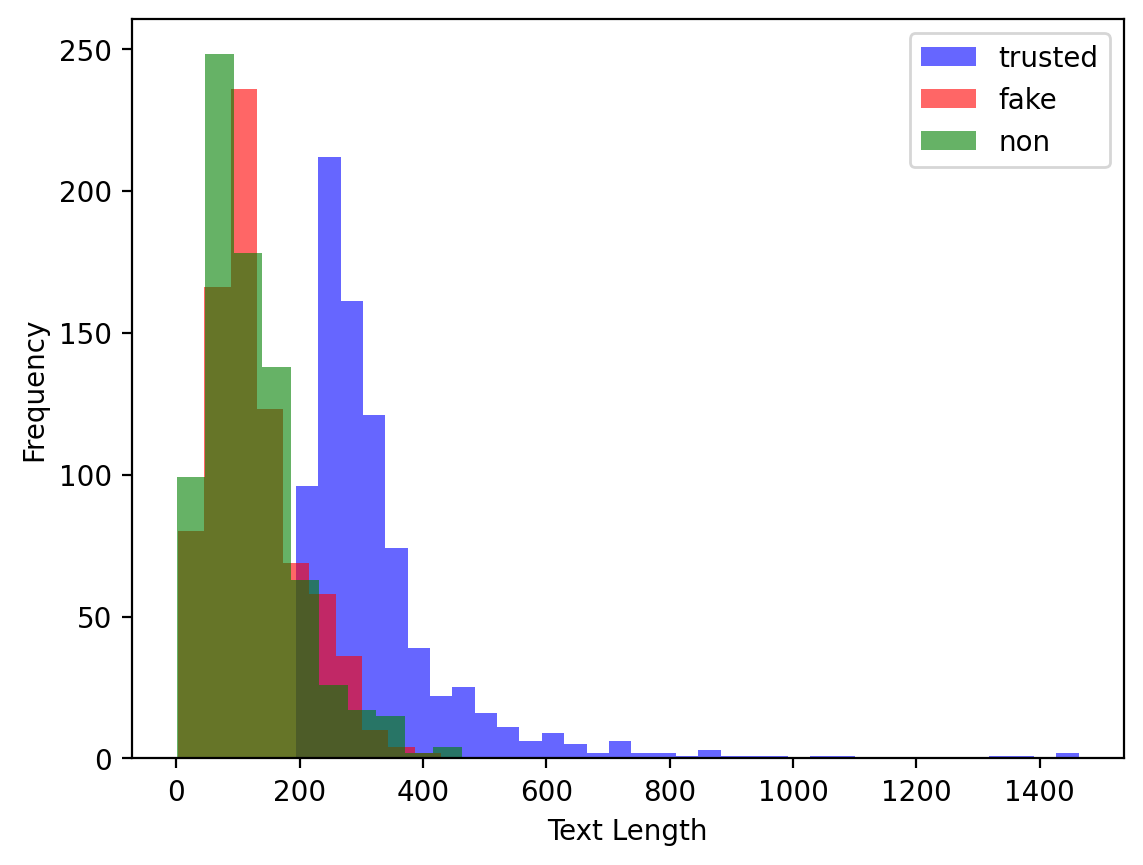

In [186]:
df[df.label=='trusted'].text_length.plot(bins=35, kind='hist', color='blue',
                                       label='trusted', alpha=0.6)
df[df.label == 'fake'].text_length.plot(kind='hist', color='red',
                                       label='fake', alpha=0.6)
df[df.label == 'non'].text_length.plot(kind='hist', color='green',
                                       label='non', alpha=0.6)
plt.legend()
plt.xlabel("Text Length")
plt.show()


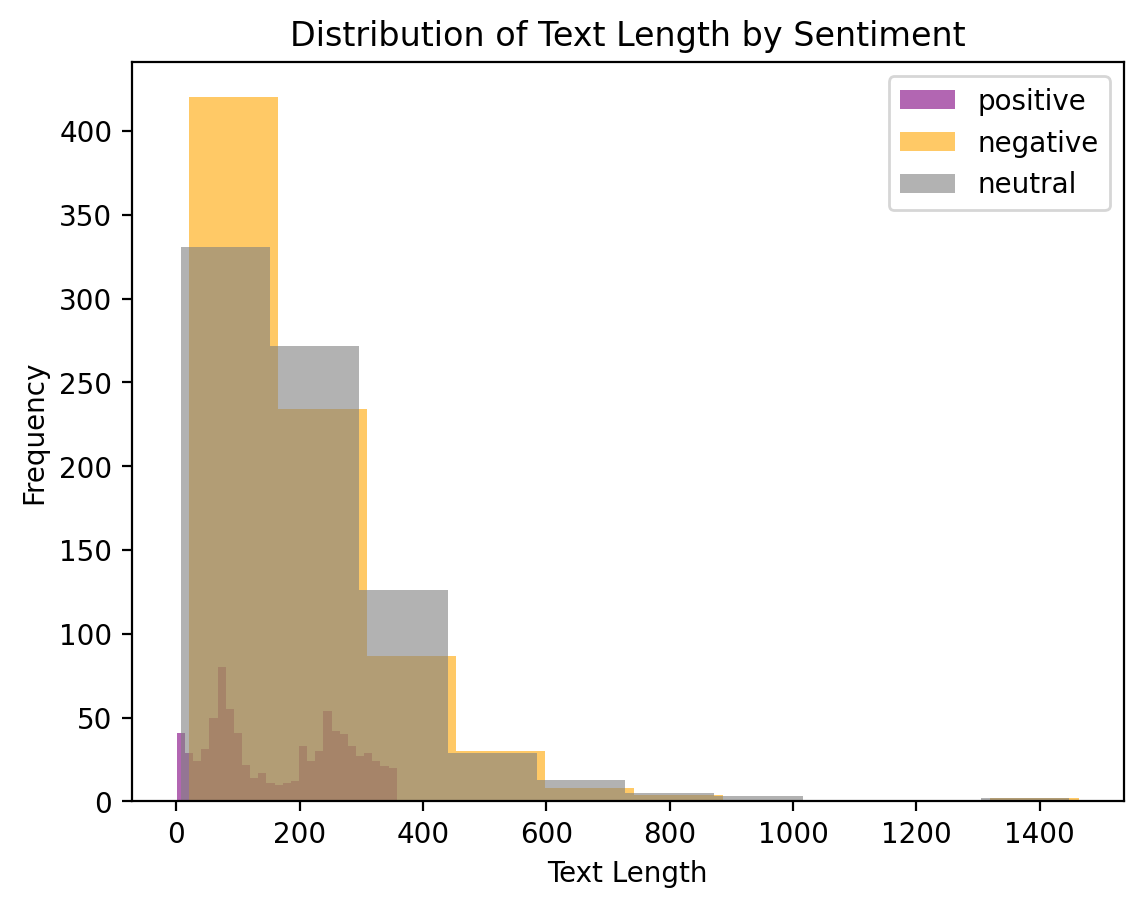

In [187]:
df[df.sentimen == 'positive'].text_length.plot(bins=35, kind='hist', color='purple',
                                               label='positive', alpha=0.6)
df[df.sentimen == 'negative'].text_length.plot(kind='hist', color='orange',
                                               label='negative', alpha=0.6)
df[df.sentimen == 'neutral'].text_length.plot(kind='hist', color='grey',
                                              label='neutral', alpha=0.6)

plt.legend()
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Length by Sentiment")
plt.show()

In [188]:
df.groupby(['label']).count()

,username,rate,date,sentimen,reviews,produk,text_length
label,,,,,,,
fake,784,784,784,784,784,784,784
non,790,790,790,790,790,790,790
trusted,822,822,822,822,822,822,822


<Axes: xlabel='label', ylabel='count'>

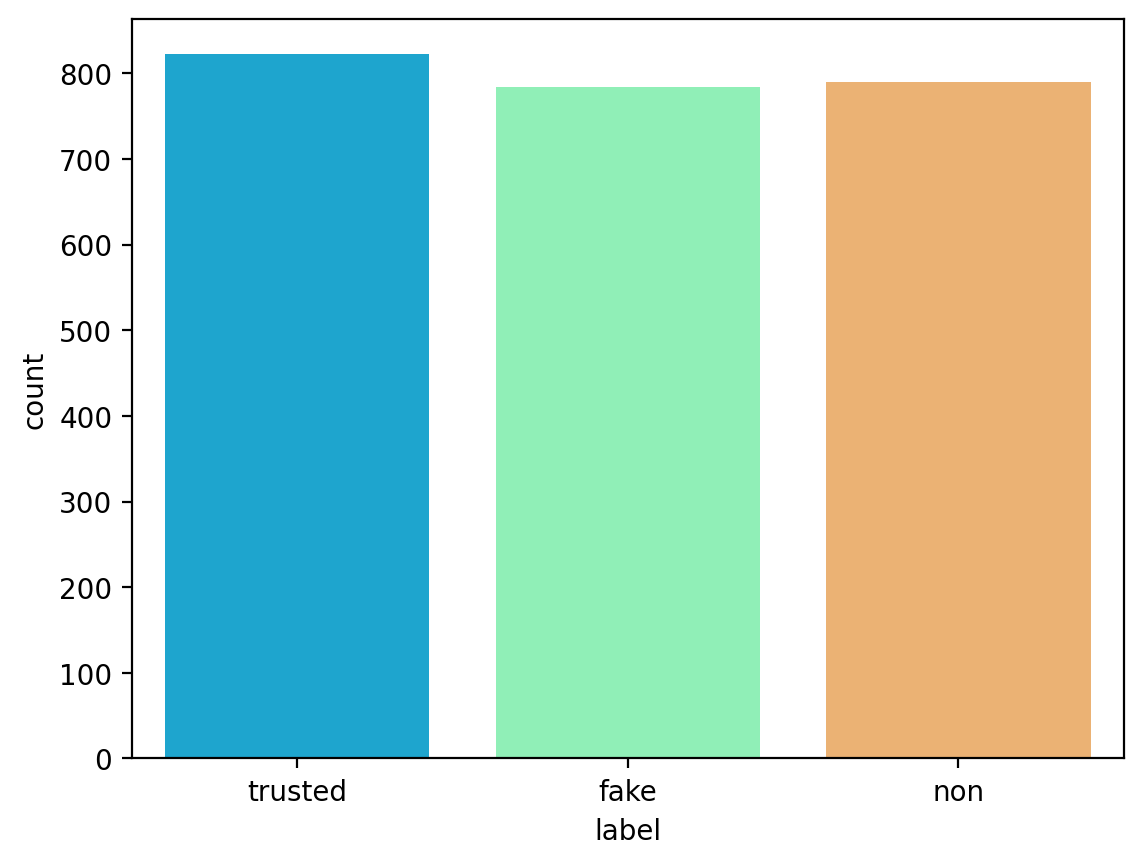

In [189]:
sns.countplot(x='label', data=df, palette='rainbow')

<Axes: xlabel='sentimen', ylabel='count'>

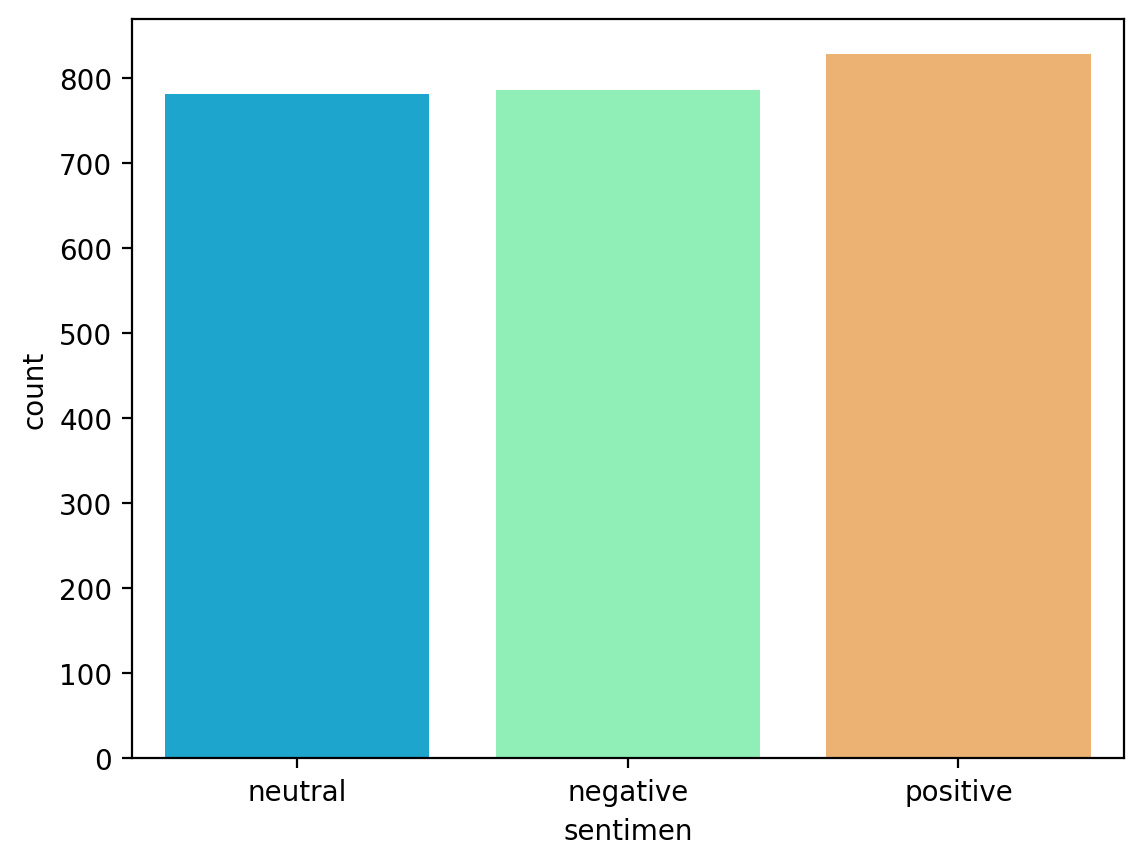

In [190]:
sns.countplot(x='sentimen', data=df, palette='rainbow')

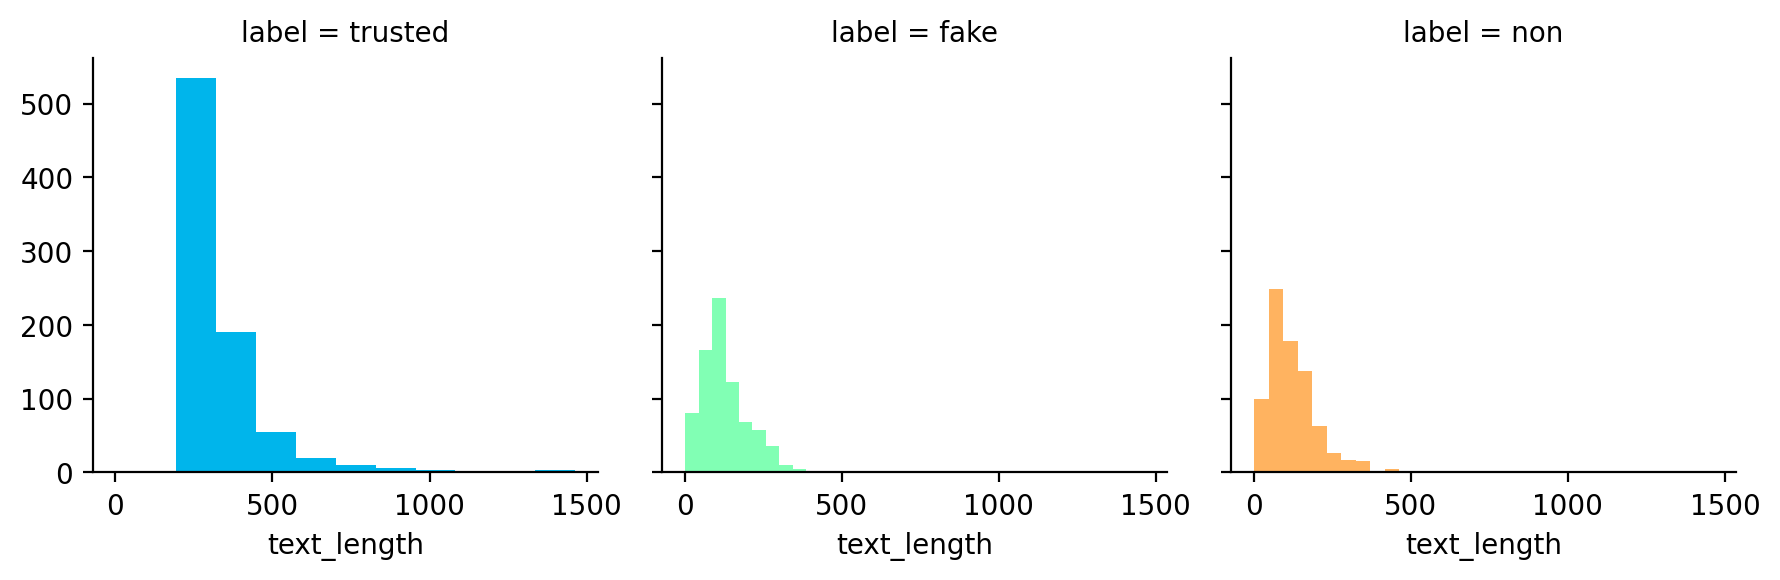

In [191]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')
plt.show()

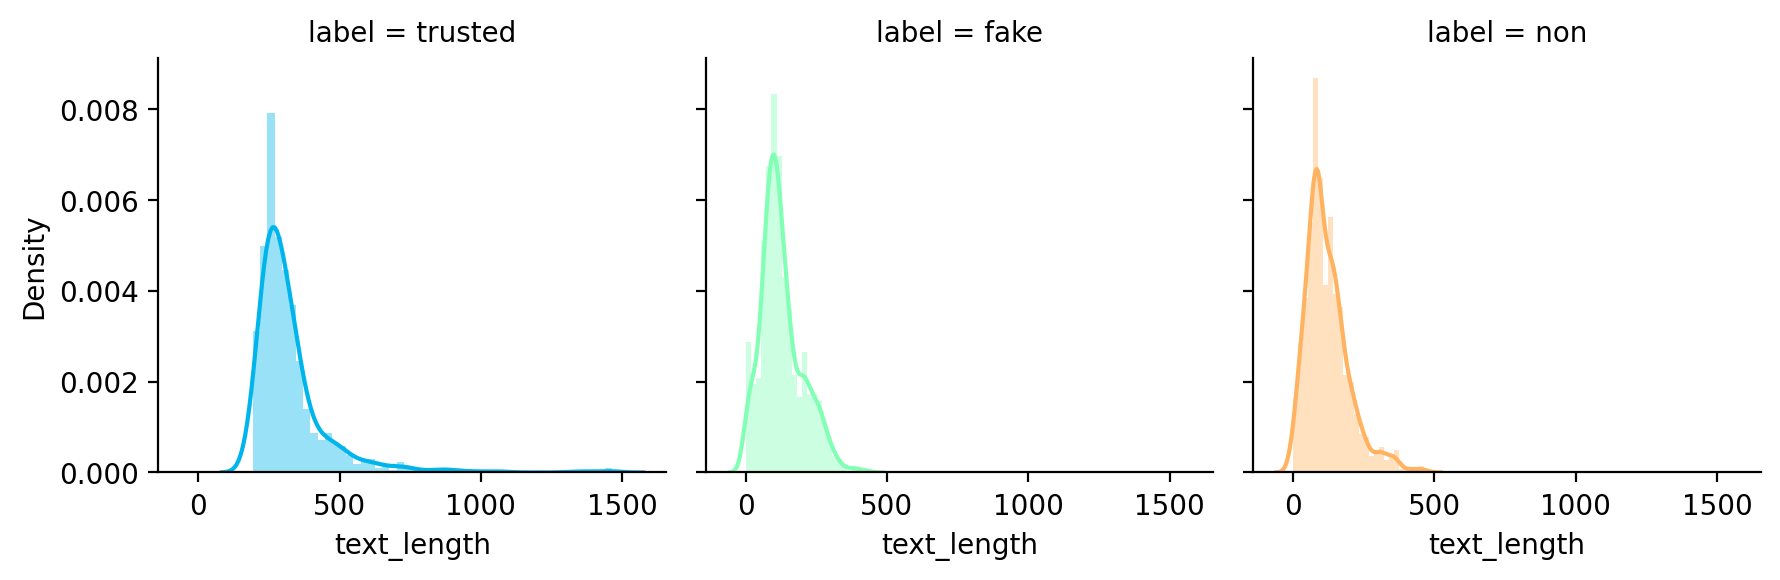

In [192]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

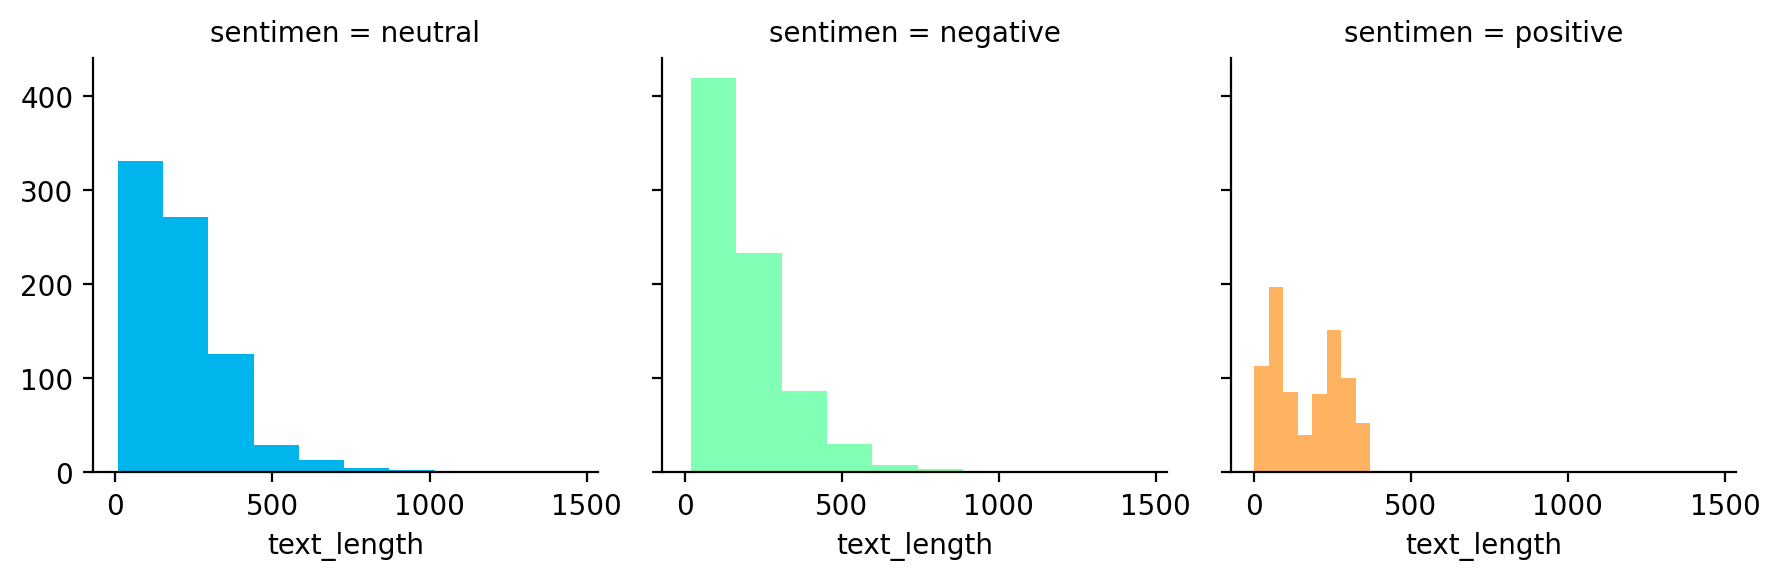

In [193]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

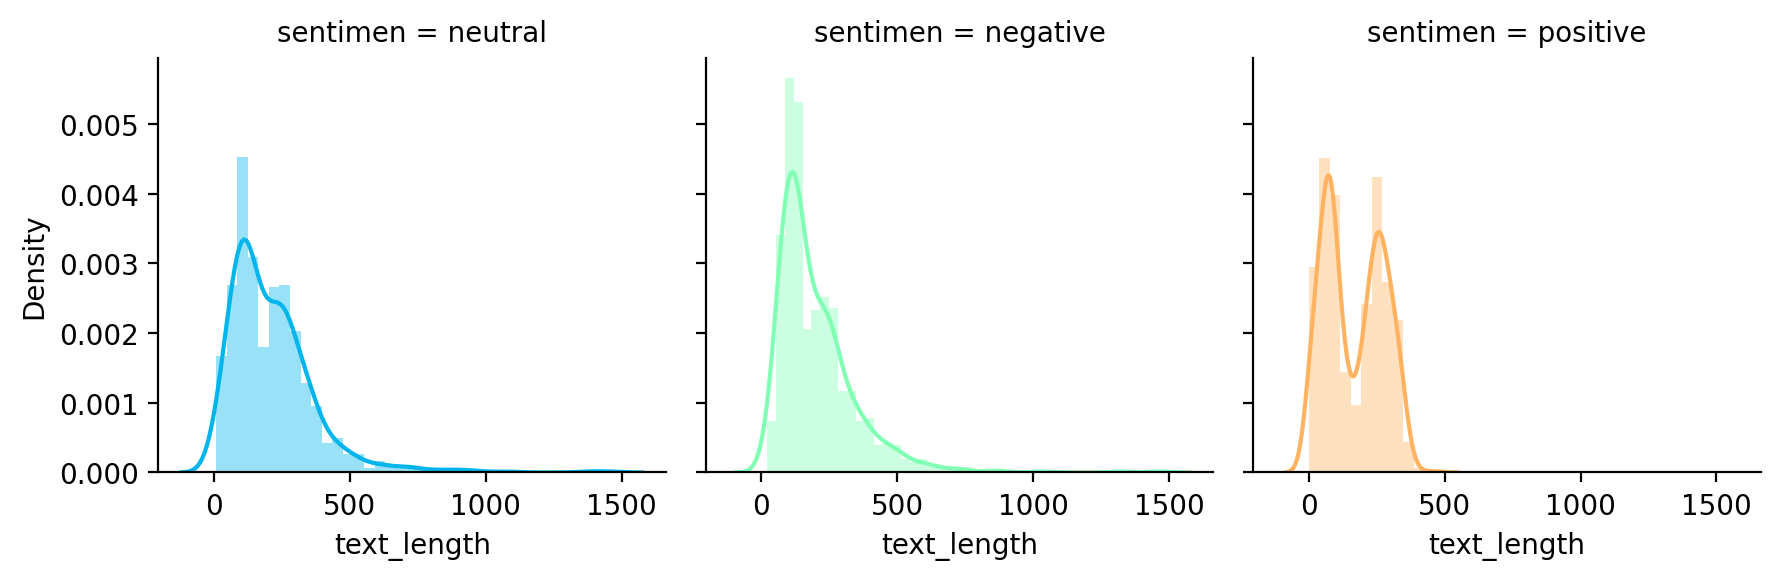

In [194]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

## Find Missing Value

In [195]:

print('Jumlah missing values disetiap kolom:\n', df.isnull().sum())

Jumlah missing values disetiap kolom:
 username       0
rate           0
date           0
label          0
sentimen       0
reviews        0
produk         0
text_length    0
dtype: int64


## Duplicate Handling

In [196]:
# Check for duplicates
duplicates = df.duplicated()

print("\nDuplicate Rows:")
print(df[duplicates])


Duplicate Rows:
Empty DataFrame
Columns: [username, rate, date, label, sentimen, reviews, produk, text_length]
Index: []


In [197]:
# df = df.drop_duplicates()

## Outliers Handling



In [198]:
df['text_length'] = df['reviews'].apply(len)

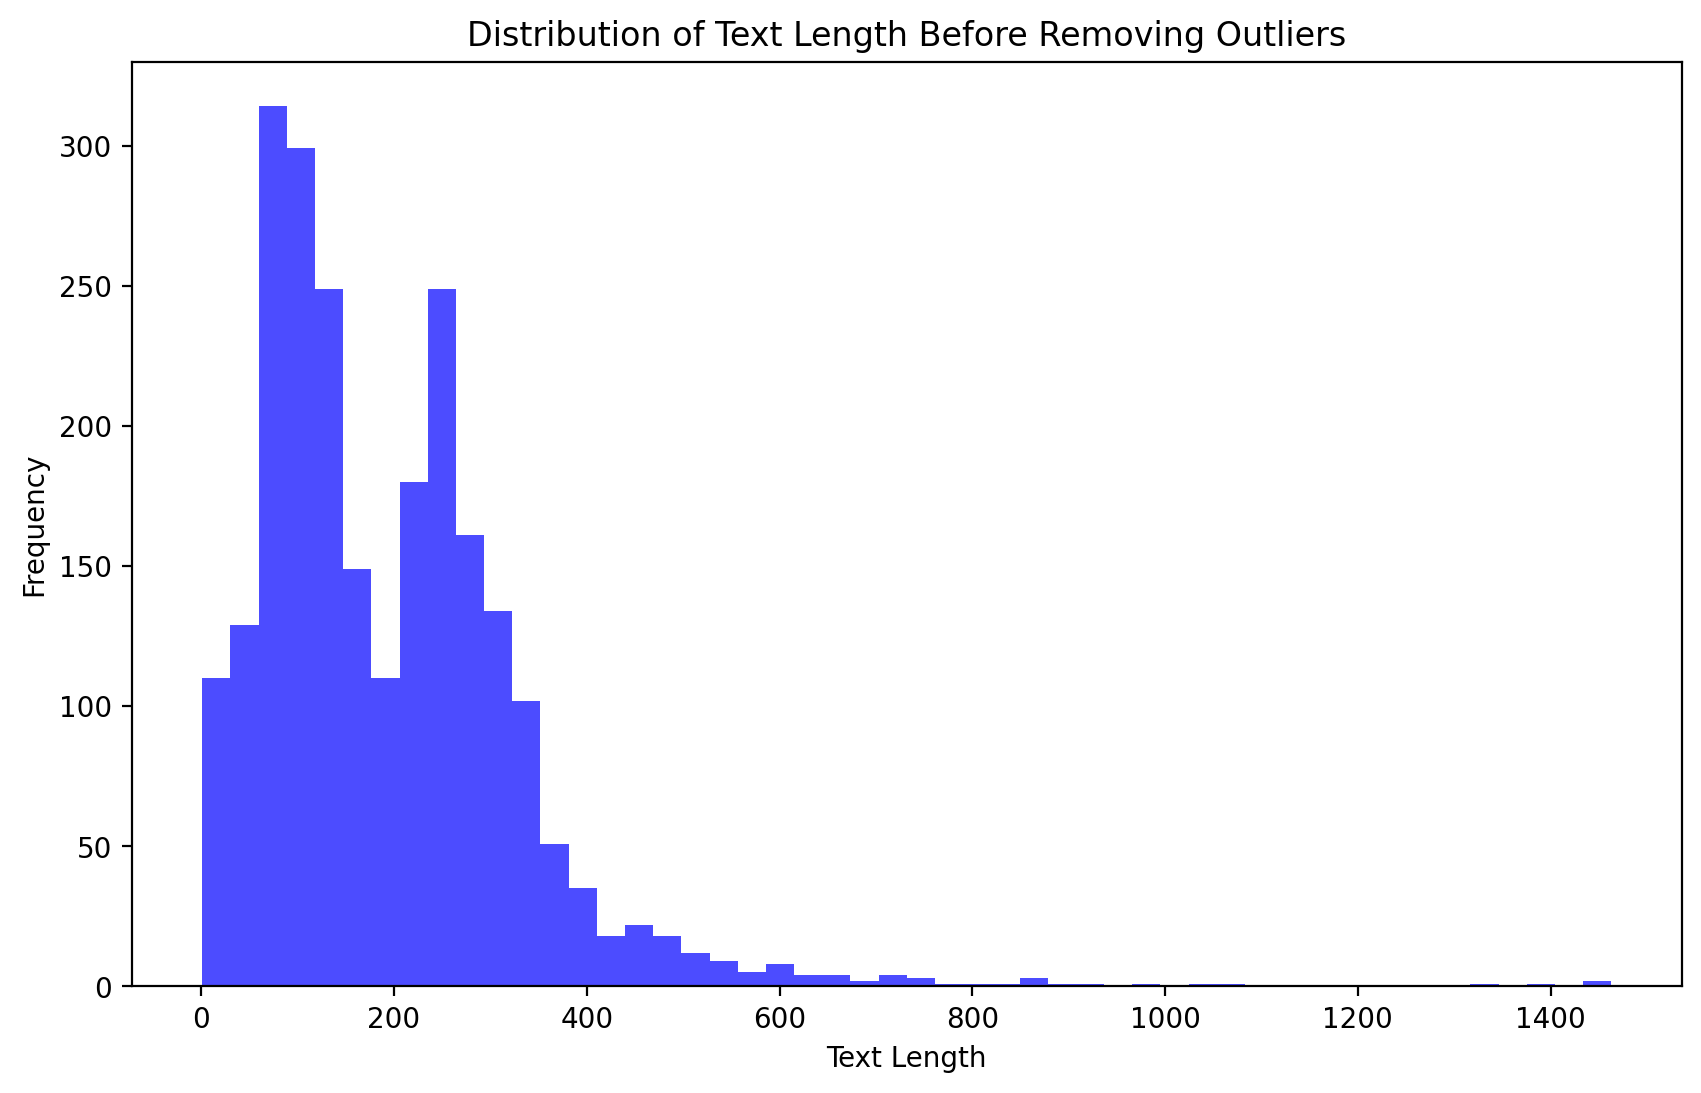

In [199]:
# Plot sebelum menghapus outlier
plt.figure(figsize=(10, 6))
df['text_length'].plot(kind='hist', bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Length Before Removing Outliers')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [200]:
df.label.value_counts()

label
trusted    822
non        790
fake       784
Name: count, dtype: int64

In [201]:
df.sentimen.value_counts()

sentimen
positive    828
negative    786
neutral     782
Name: count, dtype: int64

### Review

In [202]:
# Q1 = df[df['label'] == 'fake']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'fake']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [203]:
# Q1 = df[df['label'] == 'trusted']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'trusted']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [204]:
# Q1 = df[df['label'] == 'non']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'non']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

<Axes: xlabel='label', ylabel='text_length'>

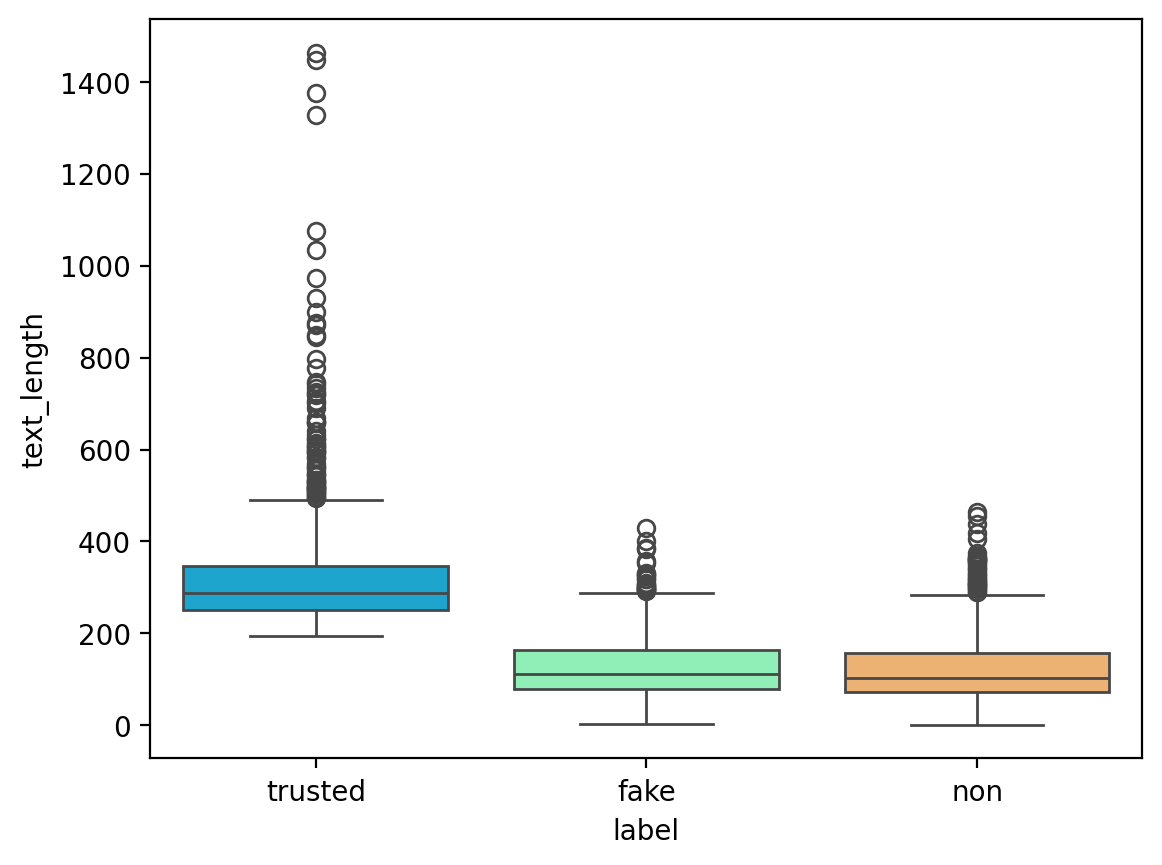

In [205]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

### Sentimen

In [206]:
# Q1 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [207]:
# Q1 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [208]:
# Q1 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

<Axes: xlabel='sentimen', ylabel='text_length'>

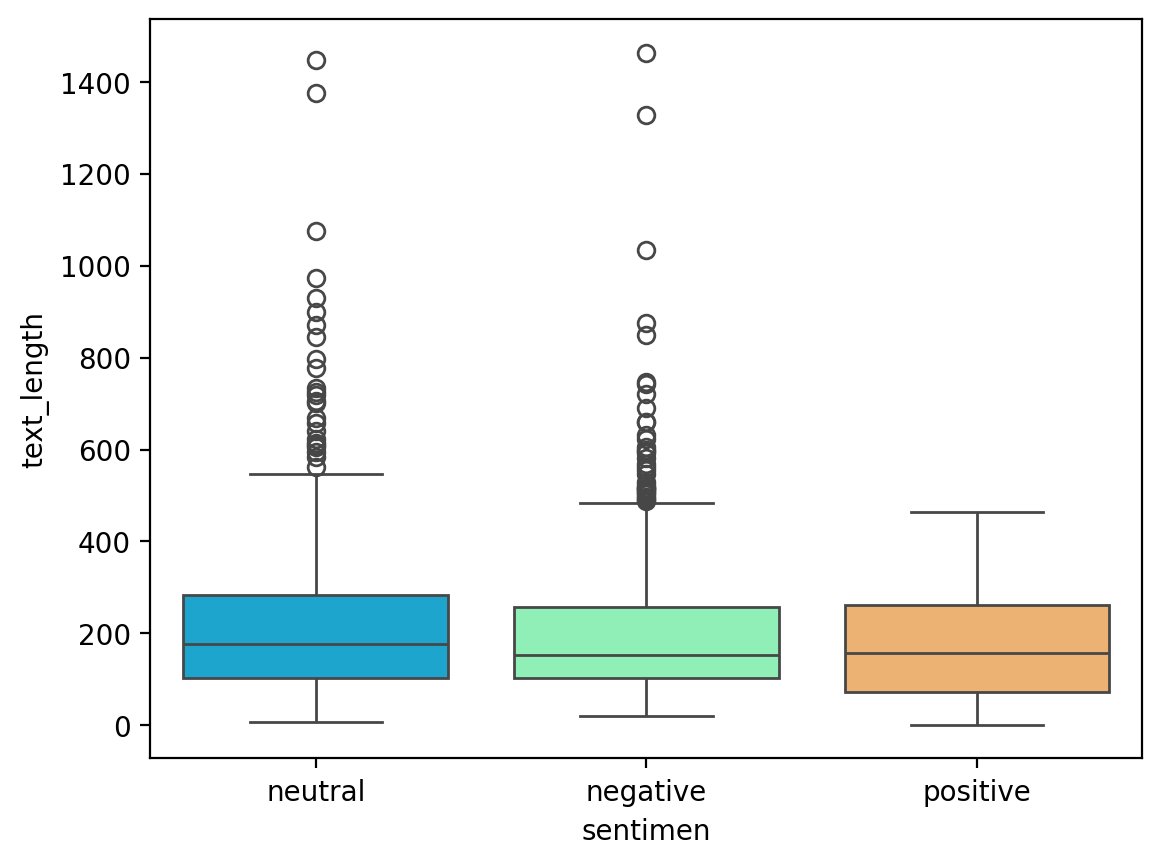

In [209]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

### Using Isolation Forest

In [210]:
#Isolation Forest

from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(df[['text_length']])
df = df[df['anomaly_score'] == 1]



## Show Final Distrubution & Outlier

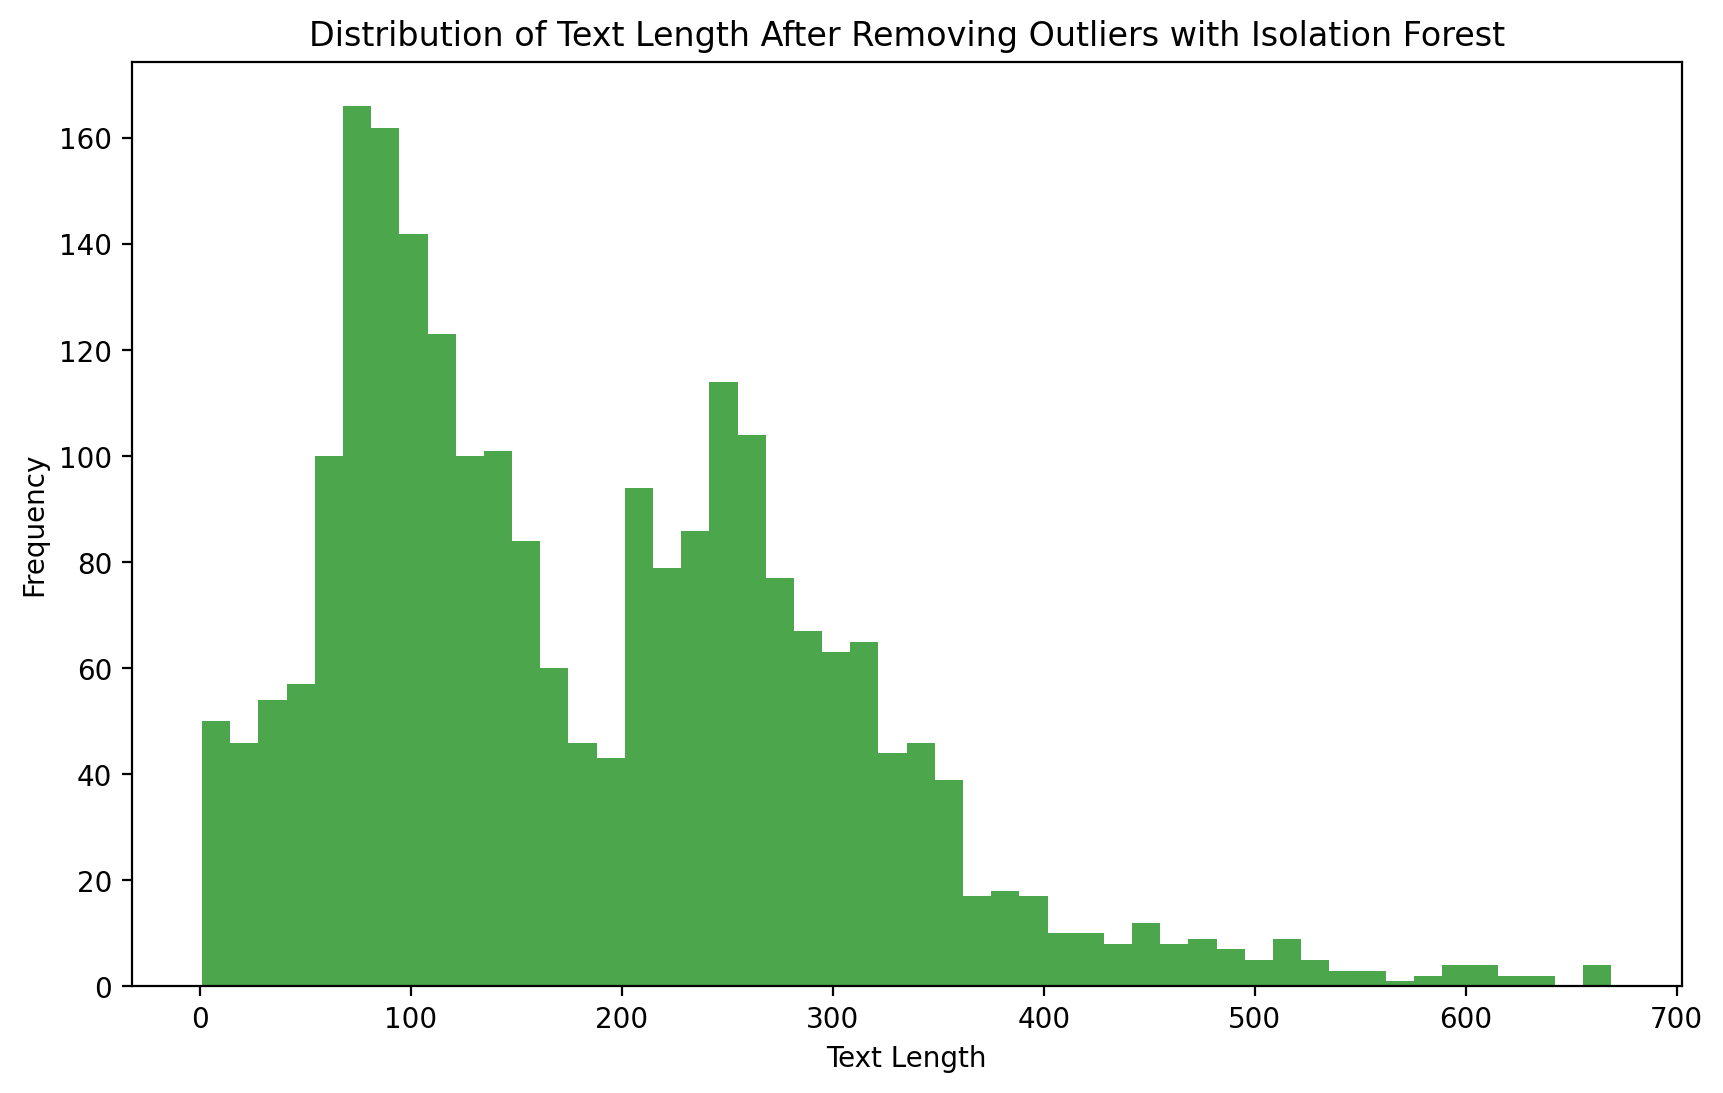

In [211]:
plt.figure(figsize=(10, 6))
df['text_length'].plot(kind='hist', bins=50, color='green', alpha=0.7)
plt.title('Distribution of Text Length After Removing Outliers with Isolation Forest')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

### Review

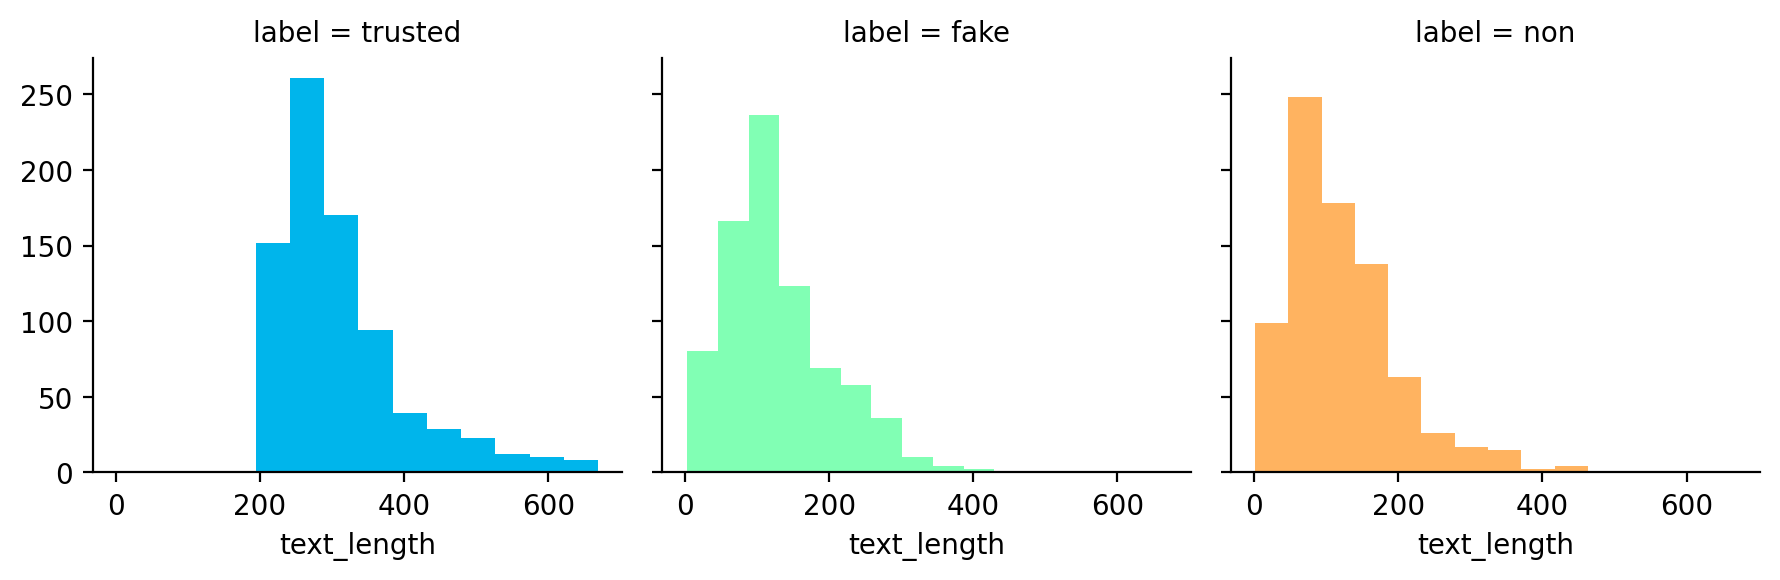

In [212]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')

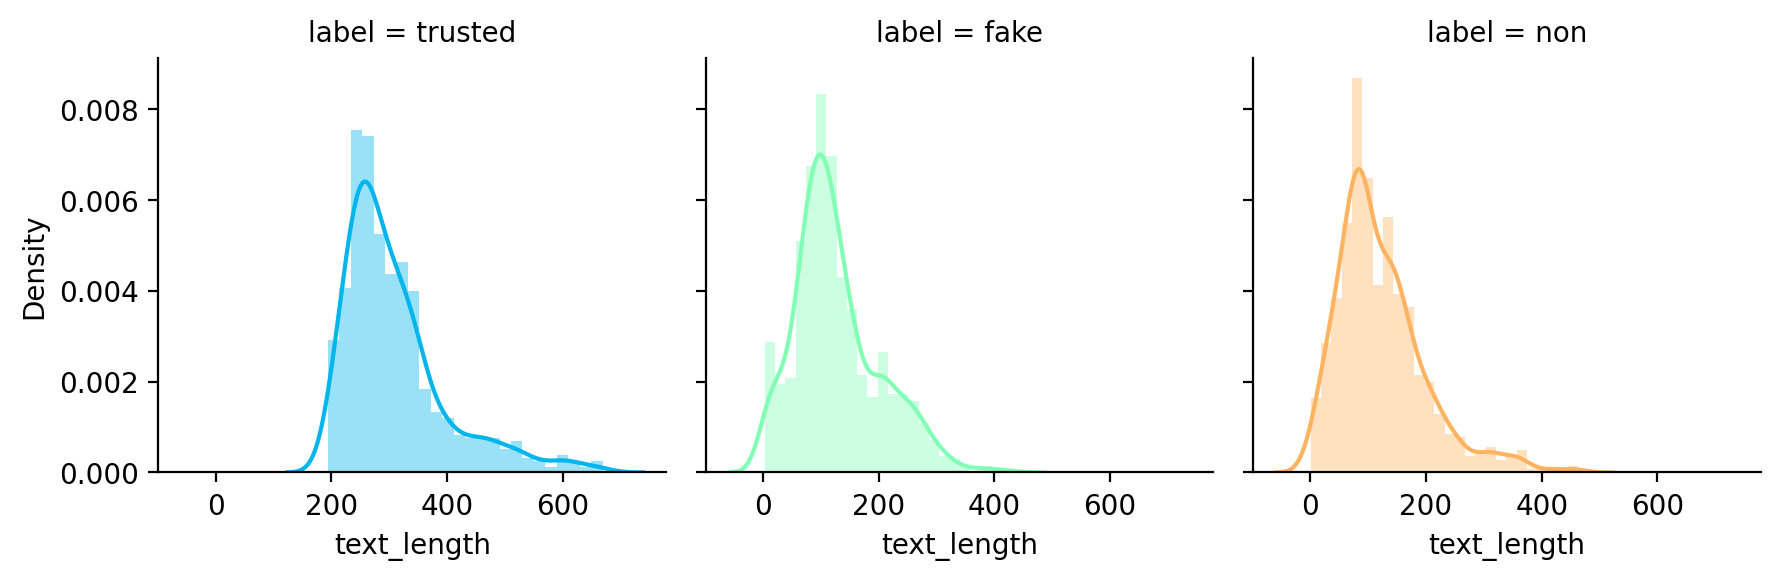

In [213]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='label', ylabel='text_length'>

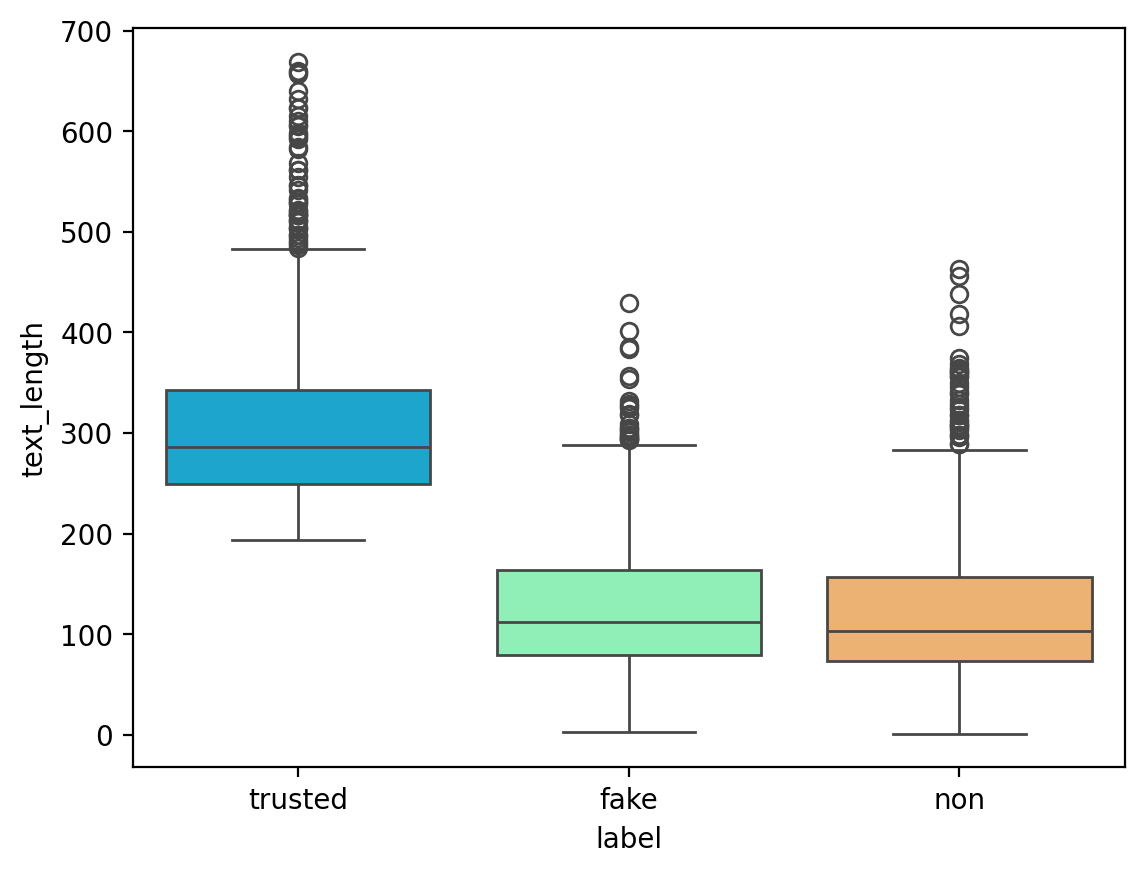

In [214]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

### Sentimen

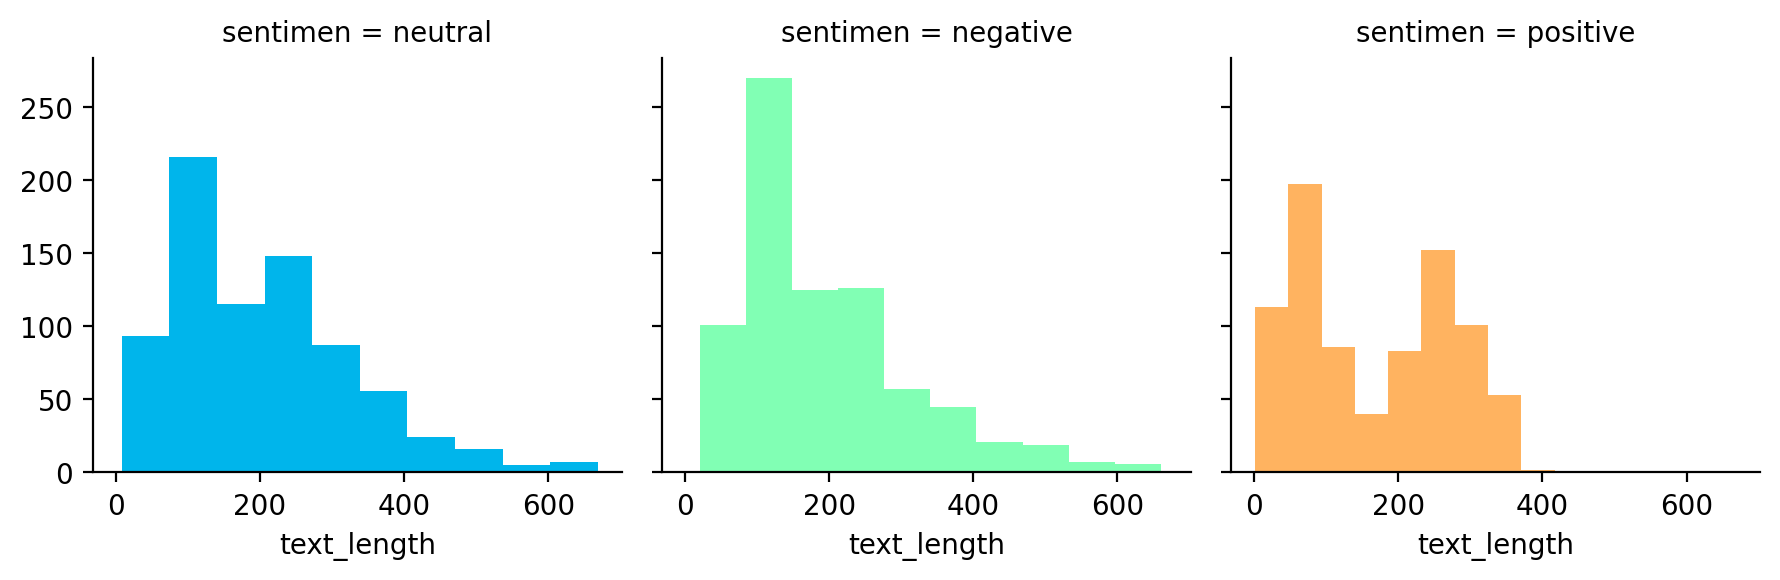

In [215]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

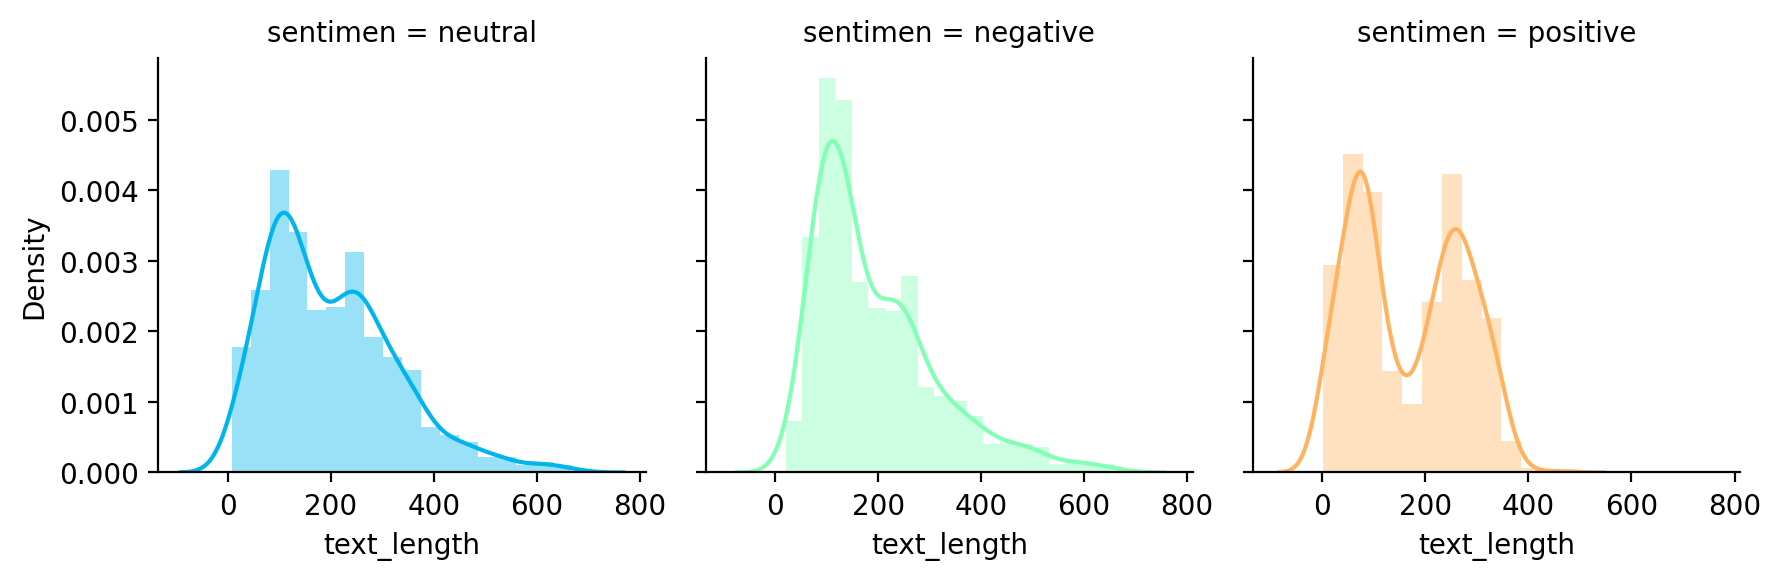

In [216]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='sentimen', ylabel='text_length'>

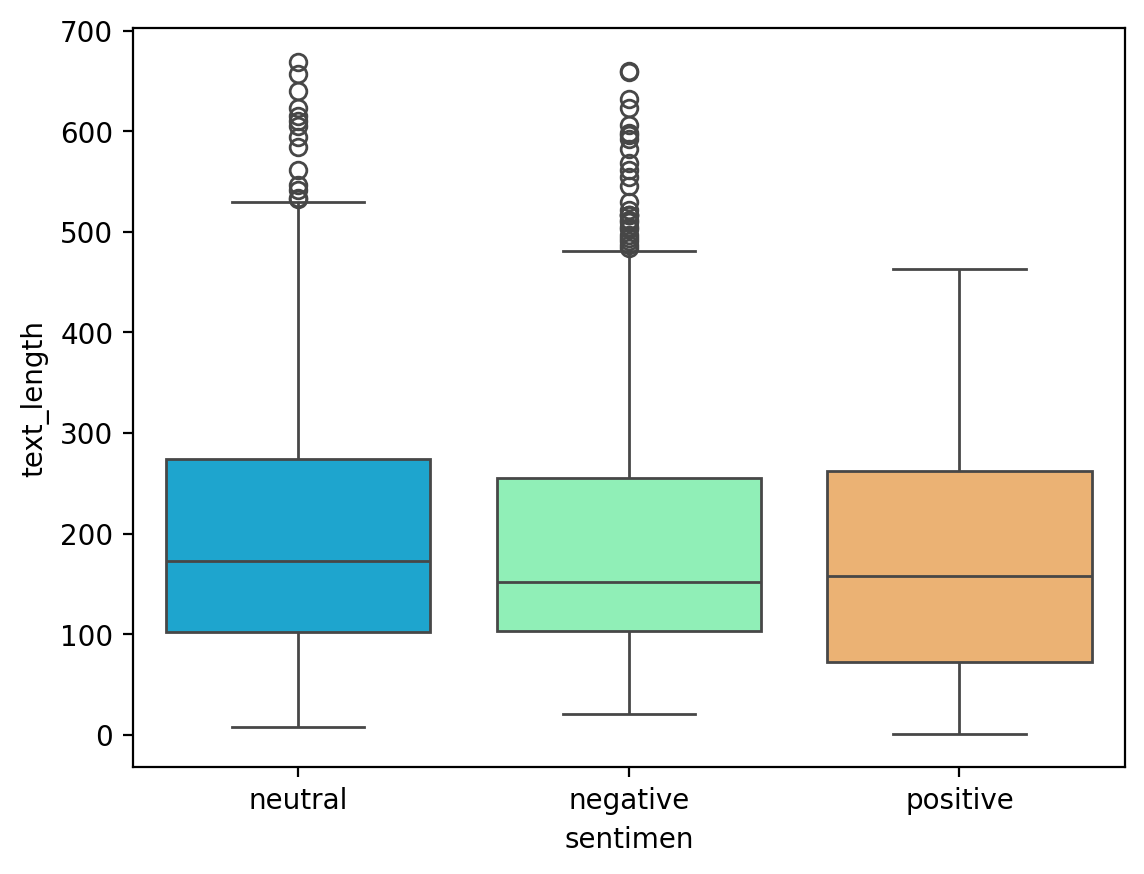

In [217]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

## Imbalance Class Handling

### Review

In [218]:
df.label.value_counts()

label
trusted    798
non        790
fake       784
Name: count, dtype: int64

In [219]:
# Resample data
label_trusted = resample(df[df['label'] == 'trusted'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

label_fake = resample(df[df['label'] == 'fake'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

label_non = resample(df[df['label'] == 'non'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

# Gabung ulang
df = pd.concat([label_trusted, label_fake, label_non])

df.label.value_counts()

label
trusted    800
fake       800
non        800
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

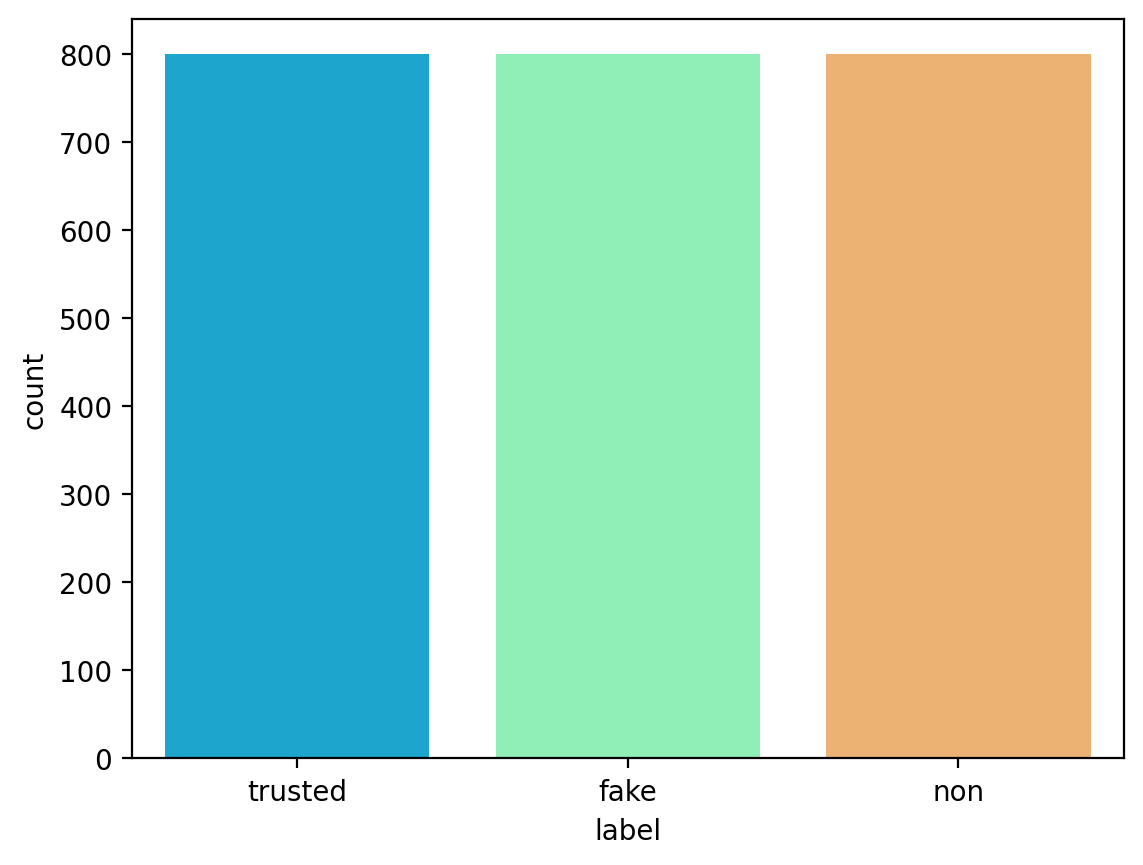

In [220]:
sns.countplot(x='label', data=df, palette='rainbow')

### Sentimen


In [221]:
df.sentimen.value_counts()

sentimen
positive    858
negative    777
neutral     765
Name: count, dtype: int64

In [222]:
# Resample data
sentimen_neutral = resample(df[df['sentimen'] == 'neutral'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

sentimen_positive = resample(df[df['sentimen'] == 'positive'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

sentimen_negative = resample(df[df['sentimen'] == 'negative'],
                                 replace=True,
                                 n_samples=800,
                                 random_state=123)

# Gabung ulang
df = pd.concat([sentimen_neutral, sentimen_positive, sentimen_negative])

df.sentimen.value_counts()

sentimen
neutral     800
positive    800
negative    800
Name: count, dtype: int64

<Axes: xlabel='sentimen', ylabel='count'>

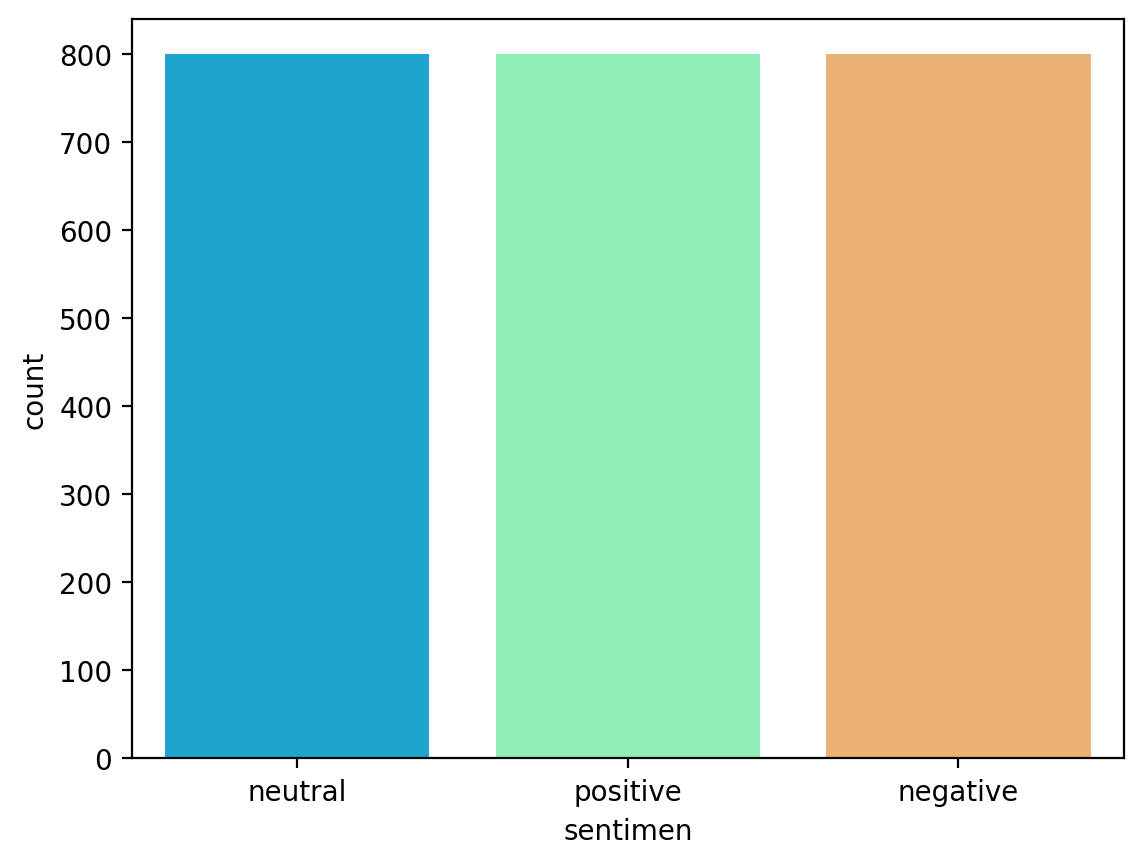

In [223]:
sns.countplot(x='sentimen', data=df, palette='rainbow')

# Data Preparation

## Features Engeneering


## Data Cleanning

### To Lowercase, Case folding

In [224]:
# merubah jenis huruf menjadi huruf kecil
def lowercase(review_text):
  low = review_text.lower()
  return low

df['lowercase_reviews'] = df['reviews'].apply(lambda low:lowercase(str(low)))

In [225]:
df[['reviews', 'lowercase_reviews']]

,reviews,lowercase_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...","ketahuilah apa jenis kulitmu dulu,,utamakan gu..."
2128,Salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek:memberikan kulit tampak lebih cerah\n tek...
2163,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau ...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,dr segi packaging sih oke2 aja dan bisa liat w...
...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kalau aku kulit kering kalau kena ac tapi kala...
242,Banyak banget yg suka sama lip liquid ini. Mun...,banyak banget yg suka sama lip liquid ini. mun...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,kebetulan dikirimin 3 shade yg berbeda. tapi t...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow n glowing cream tu ade ke merkuri yang ko...


### Remove Emoji

In [226]:
# menghapus emoji menggunakan regex dan nilai unicode dari emoji

def remove_emoji(review_text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', review_text)

df['no_emoji_reviews'] = df['lowercase_reviews'].apply(lambda emoji: remove_emoji(emoji))

In [227]:
df[['reviews', 'no_emoji_reviews']]

,reviews,no_emoji_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...","ketahuilah apa jenis kulitmu dulu,,utamakan gu..."
2128,Salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek:memberikan kulit tampak lebih cerah\n tek...
2163,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau ...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,dr segi packaging sih oke2 aja dan bisa liat w...
...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kalau aku kulit kering kalau kena ac tapi kala...
242,Banyak banget yg suka sama lip liquid ini. Mun...,banyak banget yg suka sama lip liquid ini. mun...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,kebetulan dikirimin 3 shade yg berbeda. tapi t...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow n glowing cream tu ade ke merkuri yang ko...


### Remove Hastag


In [228]:
# menghapus hashtag dari ulasan yang biasanya digunakan oleh pengguna untuk memberikan tagar

def remove_hashtag(review_text, default_replace=""):
  hashtag = re.sub(r'#\w+', default_replace, review_text)
  return hashtag

df['no_hastag_reviews'] = df['no_emoji_reviews'].apply(lambda hashtag: remove_hashtag(hashtag))

In [229]:
df[['reviews','no_hastag_reviews',]]

,reviews,no_hastag_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...","ketahuilah apa jenis kulitmu dulu,,utamakan gu..."
2128,Salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek:memberikan kulit tampak lebih cerah\n tek...
2163,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau ...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,dr segi packaging sih oke2 aja dan bisa liat w...
...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kalau aku kulit kering kalau kena ac tapi kala...
242,Banyak banget yg suka sama lip liquid ini. Mun...,banyak banget yg suka sama lip liquid ini. mun...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,kebetulan dikirimin 3 shade yg berbeda. tapi t...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow n glowing cream tu ade ke merkuri yang ko...


### Remove Punctuation & Number

In [230]:
# menghapus angka dalam ulasan

def remove_number(review_text, default_replace=" "):
  num = re.sub(r'\d+', default_replace, review_text)
  return num

df['no_number_reviews'] = df['no_hastag_reviews'].apply(lambda num: remove_number(num))

In [231]:
# menghapus tanda baca

def remove_punctuation(review_text, default_text=" "):
  list_punct = string.punctuation
  delete_punct = str.maketrans(list_punct,' '*len(list_punct))
  new_review = ' '.join(review_text.translate(delete_punct).split())

  return new_review

df['no_atribut_reviews'] = df['no_number_reviews'].apply(lambda punct: remove_punctuation(punct))

In [232]:
# menghapus superscript dalam ulasan yang biasa digunakan oleh pengguna dalam mengulangi kata

def remove_superscript(review_text):
  number = re.compile("["u"\U00002070"
                      u"\U000000B9"
                      u"\U000000B2-\U000000B3"
                      u"\U00002074-\U00002079"
                      u"\U0000207A-\U0000207E"
                      u"U0000200D"
                      "]+", flags=re.UNICODE)
  return number.sub(r'', review_text)

df['no_atribut_reviews'] = df['no_atribut_reviews'].apply(lambda num: remove_superscript(num))

In [233]:
def remove_text_special(review_text):
    # Hapus tab, newline, dan backslash
    review_text = review_text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

    # Hapus simbol
    review_text = re.sub(r'[^a-zA-Z\s]', '', review_text)

    # Hapus karakter non-ASCII
    review_text = review_text.encode('ascii', 'replace').decode('ascii')

    # Hapus URL
    review_text = re.sub(r'http\S+', '', review_text)

    return review_text

# Contoh pemanggilan fungsi pada kolom 'no_atribut_reviews'
df['no_atribut_reviews'] = df['no_atribut_reviews'].apply(remove_text_special)


In [234]:
df[['reviews','no_atribut_reviews',]]

,reviews,no_atribut_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",ketahuilah apa jenis kulitmu dulu utamakan gun...
2128,Salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek memberikan kulit tampak lebih cerah tekst...
2163,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau d...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,dr segi packaging sih oke aja dan bisa liat wa...
...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kalau aku kulit kering kalau kena ac tapi kala...
242,Banyak banget yg suka sama lip liquid ini. Mun...,banyak banget yg suka sama lip liquid ini mung...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,kebetulan dikirimin shade yg berbeda tapi tern...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow n glowing cream tu ade ke merkuri yang ko...


### Remove Repetition

In [235]:
# melakukan pembatasan jumlah huruf menjadi dua untuk mengembalikan kata ke bentuk awal
# dan menghindari terjadinya kata ganda yang memiliki arti sama tetapi berbeda penulisan

def word_repetition(review_text):
  review = re.sub(r'(.)\1+', r'\1\1', review_text)
  return review

df['no_repetition_reviews'] = df['no_atribut_reviews'].apply(lambda word: word_repetition(word))

In [236]:
# melakukan pembatasan kata berulang menjadi satu kali, seperti suka suka -> suka

def repetition(review_text):
  repeat = re.sub(r'\b(\w+)(?:\W\1\b)+', r'\1',review_text, flags=re.IGNORECASE)
  return repeat

df['no_repetition_reviews'] = df['no_repetition_reviews'].apply(lambda word: repetition(word))

In [237]:
df[['reviews','no_repetition_reviews',]]

,reviews,no_repetition_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",ketahuilah apa jenis kulitmu dulu utamakan gun...
2128,Salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek memberikan kulit tampak lebih cerah tekst...
2163,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau d...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,dr segi packaging sih oke aja dan bisa liat wa...
...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kalau aku kulit kering kalau kena ac tapi kala...
242,Banyak banget yg suka sama lip liquid ini. Mun...,banyak banget yg suka sama lip liquid ini mung...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,kebetulan dikirimin shade yg berbeda tapi tern...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow n glowing cream tu ade ke merkuri yang ko...


### Remove Whitespace

In [238]:
# menghapus spasi berlebih dalam ulasan

def remove_extra_whitespaces(review_text):
  review = re.sub(r'\s+',' ', review_text)
  return review

df['no_whitespace_reviews'] = df['no_repetition_reviews'].apply(lambda extra_spaces: remove_extra_whitespaces(extra_spaces))

In [239]:
df[['reviews','no_whitespace_reviews',]]

,reviews,no_whitespace_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",ketahuilah apa jenis kulitmu dulu utamakan gun...
2128,Salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek memberikan kulit tampak lebih cerah tekst...
2163,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau d...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,dr segi packaging sih oke aja dan bisa liat wa...
...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kalau aku kulit kering kalau kena ac tapi kala...
242,Banyak banget yg suka sama lip liquid ini. Mun...,banyak banget yg suka sama lip liquid ini mung...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,kebetulan dikirimin shade yg berbeda tapi tern...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow n glowing cream tu ade ke merkuri yang ko...


### Remove Banned Words

In [240]:
bannedword = ['uqjy', 'dehdje', 'jwdnmb', 'wxvlezuvws', 'ircel', 'swjjw', 'dmv',
         'dxrgz','qjtajuq','zzhwntdft','xywrfw' ,'fztnmdrrduy' ,'xsezuz',
         'kbyv', 'iyyveyzqkdgm', 'arlrmdjy', 'sfarif', 'sfomar',
         'syantienurxsayurbox', 'ghinaxsayurbox', 'nzxx', 'mtsco','wkwk',
         'wkwkw','wkwkwk','hihi','hihihii','hihihi','hehehe','hehehehe','hehe',
         'huhu','huhuu','ancok','guak','cokcok','hhmm','annya','huftt','jir','srg']

re_banned_words = re.compile(r"\b(" + "|".join(bannedword) + ")\\W", re.I)

def RemoveBannedWords(toPrint):
    global re_banned_words
    return re_banned_words.sub("", toPrint)

df['no_banned_reviews'] = df['no_whitespace_reviews'].apply(lambda banned:RemoveBannedWords(banned))

In [241]:
df[['reviews','no_banned_reviews']]

,reviews,no_banned_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",ketahuilah apa jenis kulitmu dulu utamakan gun...
2128,Salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek memberikan kulit tampak lebih cerah tekst...
2163,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau d...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,dr segi packaging sih oke aja dan bisa liat wa...
...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kalau aku kulit kering kalau kena ac tapi kala...
242,Banyak banget yg suka sama lip liquid ini. Mun...,banyak banget yg suka sama lip liquid ini mung...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,kebetulan dikirimin shade yg berbeda tapi tern...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow n glowing cream tu ade ke merkuri yang ko...


### Slang Words

In [242]:
import urllib.request

# URL file dari GitHub
github_url = "https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/slang.txt"

# Nama file lokal untuk menyimpan hasil unduhan
slangword_file = "slang.txt"

# Unduh file dari URL GitHub
urllib.request.urlretrieve(github_url, slangword_file)

# Buka file yang telah diunduh untuk dibaca
slangs = open(slangword_file, "r", encoding="utf-8", errors='replace')


In [243]:
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

print(clear_slangs)

[['& ', ' dan'], ['dr ', ' dari'], ['abis ', ' habis'], ['ad ', ' ada'], ['alhmdulillah ', ' alhamdulillah'], ['alhamdulilah ', ' alhamdulillah'], ['alhamdulillaah ', ' alhamdulillah'], ['alhamdulillah ', ' alhamdulillah'], ['adminnya ', ' admin nya'], ['account ', ' akun'], ['asiikk ', ' asyik'], ['alpukatnya ', ' alpukat nya'], ['amin ', ' aamiin'], ['aplikasinnya ', ' aplikasi nya'], ['aplikasinya ', ' aplikasi nya'], ['awesome ', ' luar biasa'], ['asyilk ', ' asyik'], ['antaran ', ' pengantaran'], ['apus ', ' hapus'], ['ampe ', ' sampai'], ['almt ', ' alamat'], ['almat ', ' alamat'], ['alamt ', ' alamat'], ['almtnya ', ' alamatnya'], ['apknya ', ' aplikasinya'], ['antri ', ' antre'], ['adl ', ' adalah'], ['awalnnya ', ' awalnya'], ['asem ', ' asam'], ['alumunium ', ' aluminium'], ['abis ', ' habis'], ['areaku ', ' area saya'], ['alpulat ', ' alpukat'], ['adlah ', ' adalah'], ['applikasi ', ' aplikasi'], ['apps ', ' aplikasi'], ['app ', ' aplikasi'], ['afordable ', ' affordable'], [

In [244]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}
dict_slangs

{'&': 'dan',
 'dr': 'dari',
 'abis': 'habis',
 'ad': 'ada',
 'alhmdulillah': 'alhamdulillah',
 'alhamdulilah': 'alhamdulillah',
 'alhamdulillaah': 'alhamdulillah',
 'alhamdulillah': 'alhamdulillah',
 'adminnya': 'admin nya',
 'account': 'akun',
 'asiikk': 'asyik',
 'alpukatnya': 'alpukat nya',
 'amin': 'aamiin',
 'aplikasinnya': 'aplikasi nya',
 'aplikasinya': 'aplikasi nya',
 'awesome': 'luar biasa',
 'asyilk': 'asyik',
 'antaran': 'pengantaran',
 'apus': 'hapus',
 'ampe': 'sampai',
 'almt': 'alamat',
 'almat': 'alamat',
 'alamt': 'alamat',
 'almtnya': 'alamatnya',
 'apknya': 'aplikasinya',
 'antri': 'antre',
 'adl': 'adalah',
 'awalnnya': 'awalnya',
 'asem': 'asam',
 'alumunium': 'aluminium',
 'areaku': 'area saya',
 'alpulat': 'alpukat',
 'adlah': 'adalah',
 'applikasi': 'aplikasi',
 'apps': 'aplikasi',
 'app': 'aplikasi',
 'afordable': 'affordable',
 'agent': 'agen',
 'agus': 'hangus',
 'apk': 'aplikasi',
 'appsnya': 'aplikasinya',
 'aah': 'ah',
 'apakh': 'apakah',
 'apalgi': 'apal

In [245]:
import nltk
nltk.download('punkt')
from textblob import TextBlob
clean_text = []
for review in df['no_banned_reviews']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [246]:
df['no_slang_reviews'] = clean_text


In [247]:
df['clean_reviews'] = df['no_slang_reviews']

In [248]:
df[['reviews','clean_reviews']]

,reviews,clean_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",ketahuilah apa jenis kulitmu dahulu utamakan g...
2128,Salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek memberikan kulit tampak lebih cerah tekst...
2163,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau d...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,dari segi packaging sih oke saja dan bisa liha...
...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kalau aku kulit kering kalau kena ac tapi kala...
242,Banyak banget yg suka sama lip liquid ini. Mun...,banyak banget yang suka sama lip liquid ini mu...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,kebetulan dikirimin shade yang berbeda tapi te...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow dan glowing cream tu ade ke merkuri yang ...


# Tokenize

In [249]:
from nltk.tokenize import word_tokenize
def word_tokenize_wrapper(text):
    return word_tokenize(text)

def tokenize(word):
  word = word.split(" ")
  return word

In [250]:
import nltk
nltk.download('punkt')
df['tokens_reviews'] = df['clean_reviews'].apply(word_tokenize_wrapper)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [251]:
df[['reviews','clean_reviews','tokens_reviews']]

,reviews,clean_reviews,tokens_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",ketahuilah apa jenis kulitmu dahulu utamakan g...,"[ketahuilah, apa, jenis, kulitmu, dahulu, utam..."
2128,Salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,"[salah, satu, facial, wash, dari, drugstore, y..."
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek memberikan kulit tampak lebih cerah tekst...,"[efek, memberikan, kulit, tampak, lebih, cerah..."
2163,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau d...,"[cukup, memuaskan, dengan, harga, yang, terjan..."
119,Dr segi packaging sih oke2 aja dan bisa liat w...,dari segi packaging sih oke saja dan bisa liha...,"[dari, segi, packaging, sih, oke, saja, dan, b..."
...,...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kalau aku kulit kering kalau kena ac tapi kala...,"[kalau, aku, kulit, kering, kalau, kena, ac, t..."
242,Banyak banget yg suka sama lip liquid ini. Mun...,banyak banget yang suka sama lip liquid ini mu...,"[banyak, banget, yang, suka, sama, lip, liquid..."
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,kebetulan dikirimin shade yang berbeda tapi te...,"[kebetulan, dikirimin, shade, yang, berbeda, t..."
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow dan glowing cream tu ade ke merkuri yang ...,"[glow, dan, glowing, cream, tu, ade, ke, merku..."


# Normalization

#### Stopword Removal

In [252]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [253]:
from nltk.corpus import stopwords
list_stopwords = stopwords.words('indonesian')
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       'yah'])

txt_stopword = pd.read_csv("https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/82c73387636132ec7faa30c99ef5e788b3bf62bd/stopwords.txt", names= ["stopwords"], header = None)
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]
df['stopword_reviews'] = df['tokens_reviews'].apply(stopwords_removal)

In [254]:
df[['reviews','tokens_reviews','stopword_reviews']]

,reviews,tokens_reviews,stopword_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...","[ketahuilah, apa, jenis, kulitmu, dahulu, utam...","[ketahuilah, jenis, kulitmu, utamakan, produk,..."
2128,Salah satu facial wash dari drugstore yang lay...,"[salah, satu, facial, wash, dari, drugstore, y...","[salah, facial, wash, drugstore, layak, dicoba..."
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,"[efek, memberikan, kulit, tampak, lebih, cerah...","[efek, kulit, cerah, tekstur, lembut, nyaman, ..."
2163,cukup memuaskan dengan harga yang terjangkau ...,"[cukup, memuaskan, dengan, harga, yang, terjan...","[memuaskan, harga, terjangkau, kualitas, lumay..."
119,Dr segi packaging sih oke2 aja dan bisa liat w...,"[dari, segi, packaging, sih, oke, saja, dan, b...","[segi, packaging, oke, warna, produk, dalamnya..."
...,...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,"[kalau, aku, kulit, kering, kalau, kena, ac, t...","[kulit, kering, ac, ac, berminyak, kakak, paka..."
242,Banyak banget yg suka sama lip liquid ini. Mun...,"[banyak, banget, yang, suka, sama, lip, liquid...","[banget, suka, lip, liquid, harganya, murah, b..."
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,"[kebetulan, dikirimin, shade, yang, berbeda, t...","[dikirimin, shade, berbeda, sesuai, ekspektasi..."
1829,Glow n glowing cream tu ade ke merkuri yang ko...,"[glow, dan, glowing, cream, tu, ade, ke, merku...","[glow, glowing, cream, merkuri, kotak, warna, ..."


#### Stemming

In [255]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

In [256]:
def back_to_root(review_text):
  stop_token = ' '.join(review_text)
  stem = StemmerFactory()
  create_stem = stem.create_stemmer()
  result_stem = create_stem.stem(stop_token)
  return result_stem

df['stem_reviews'] = df['stopword_reviews'].apply(lambda stem:back_to_root(stem))

In [257]:
df[['reviews','tokens_reviews','stopword_reviews','stem_reviews']]

,reviews,tokens_reviews,stopword_reviews,stem_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...","[ketahuilah, apa, jenis, kulitmu, dahulu, utam...","[ketahuilah, jenis, kulitmu, utamakan, produk,...",tahu jenis kulit utama produk kandung hydratin...
2128,Salah satu facial wash dari drugstore yang lay...,"[salah, satu, facial, wash, dari, drugstore, y...","[salah, facial, wash, drugstore, layak, dicoba...",salah facial wash drugstore layak coba busa ku...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,"[efek, memberikan, kulit, tampak, lebih, cerah...","[efek, kulit, cerah, tekstur, lembut, nyaman, ...",efek kulit cerah tekstur lembut nyaman asli ba...
2163,cukup memuaskan dengan harga yang terjangkau ...,"[cukup, memuaskan, dengan, harga, yang, terjan...","[memuaskan, harga, terjangkau, kualitas, lumay...",muas harga jangkau kualitas lumayan sedia mark...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,"[dari, segi, packaging, sih, oke, saja, dan, b...","[segi, packaging, oke, warna, produk, dalamnya...",segi packaging oke warna produk dalam pas dico...
...,...,...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,"[kalau, aku, kulit, kering, kalau, kena, ac, t...","[kulit, kering, ac, ac, berminyak, kakak, paka...",kulit kering ac ac minyak kakak pakai moisturi...
242,Banyak banget yg suka sama lip liquid ini. Mun...,"[banyak, banget, yang, suka, sama, lip, liquid...","[banget, suka, lip, liquid, harganya, murah, b...",banget suka lip liquid harga murah banget warn...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,"[kebetulan, dikirimin, shade, yang, berbeda, t...","[dikirimin, shade, berbeda, sesuai, ekspektasi...",dikirimin shade beda sesuai ekspektasi tekstur...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,"[glow, dan, glowing, cream, tu, ade, ke, merku...","[glow, glowing, cream, merkuri, kotak, warna, ...",glow glowing cream merkuri kotak warna hijau


In [258]:
df[['reviews','stem_reviews']]

,reviews,stem_reviews
1945,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",tahu jenis kulit utama produk kandung hydratin...
2128,Salah satu facial wash dari drugstore yang lay...,salah facial wash drugstore layak coba busa ku...
1050,Efek:memberikan kulit tampak lebih cerah\n Tek...,efek kulit cerah tekstur lembut nyaman asli ba...
2163,cukup memuaskan dengan harga yang terjangkau ...,muas harga jangkau kualitas lumayan sedia mark...
119,Dr segi packaging sih oke2 aja dan bisa liat w...,segi packaging oke warna produk dalam pas dico...
...,...,...
1848,kalau aku kulit kering kalau kena ac tapi kala...,kulit kering ac ac minyak kakak pakai moisturi...
242,Banyak banget yg suka sama lip liquid ini. Mun...,banget suka lip liquid harga murah banget warn...
123,Kebetulan dikirimin 3 shade yg berbeda. Tapi t...,dikirimin shade beda sesuai ekspektasi tekstur...
1829,Glow n glowing cream tu ade ke merkuri yang ko...,glow glowing cream merkuri kotak warna hijau


# Result Data Cleaned


In [259]:
df.head()

,username,rate,date,label,sentimen,reviews,produk,text_length,anomaly_score,lowercase_reviews,...,no_number_reviews,no_atribut_reviews,no_repetition_reviews,no_whitespace_reviews,no_banned_reviews,no_slang_reviews,clean_reviews,tokens_reviews,stopword_reviews,stem_reviews
1945,nadiadiani_,3,19-03-2021 6:58,non,neutral,"Ketahuilah apa jenis kulitmu dulu,,utamakan gu...",Acnes Creamy Wash,282,1,"ketahuilah apa jenis kulitmu dulu,,utamakan gu...",...,"ketahuilah apa jenis kulitmu dulu,,utamakan gu...",ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dulu utamakan gun...,ketahuilah apa jenis kulitmu dahulu utamakan g...,ketahuilah apa jenis kulitmu dahulu utamakan g...,"[ketahuilah, apa, jenis, kulitmu, dahulu, utam...","[ketahuilah, jenis, kulitmu, utamakan, produk,...",tahu jenis kulit utama produk kandung hydratin...
2128,jiminee10,3,31-08-2022 5:02,fake,neutral,Salah satu facial wash dari drugstore yang lay...,Acnes Creamy Wash,167,1,salah satu facial wash dari drugstore yang lay...,...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,salah satu facial wash dari drugstore yang lay...,"[salah, satu, facial, wash, dari, drugstore, y...","[salah, facial, wash, drugstore, layak, dicoba...",salah facial wash drugstore layak coba busa ku...
1050,srihastutik1987,3,2024-05-22 22:24,fake,neutral,Efek:memberikan kulit tampak lebih cerah\n Tek...,MS GLOW FACIAL WASH,103,1,efek:memberikan kulit tampak lebih cerah\n tek...,...,efek:memberikan kulit tampak lebih cerah\n tek...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,efek memberikan kulit tampak lebih cerah tekst...,"[efek, memberikan, kulit, tampak, lebih, cerah...","[efek, kulit, cerah, tekstur, lembut, nyaman, ...",efek kulit cerah tekstur lembut nyaman asli ba...
2163,Aisyah_18,3,01-11-2021 11:32,fake,neutral,cukup memuaskan dengan harga yang terjangkau ...,Acnes Creamy Wash,104,1,cukup memuaskan dengan harga yang terjangkau ...,...,cukup memuaskan dengan harga yang terjangkau ...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,cukup memuaskan dengan harga yang terjangkau d...,"[cukup, memuaskan, dengan, harga, yang, terjan...","[memuaskan, harga, terjangkau, kualitas, lumay...",muas harga jangkau kualitas lumayan sedia mark...
119,christinjuniarti,3,29-06-2018 1:01,trusted,neutral,Dr segi packaging sih oke2 aja dan bisa liat w...,Lip Cream LA Girl,431,1,dr segi packaging sih oke2 aja dan bisa liat w...,...,dr segi packaging sih oke aja dan bisa liat w...,dr segi packaging sih oke aja dan bisa liat wa...,dr segi packaging sih oke aja dan bisa liat wa...,dr segi packaging sih oke aja dan bisa liat wa...,dr segi packaging sih oke aja dan bisa liat wa...,dari segi packaging sih oke saja dan bisa liha...,dari segi packaging sih oke saja dan bisa liha...,"[dari, segi, packaging, sih, oke, saja, dan, b...","[segi, packaging, oke, warna, produk, dalamnya...",segi packaging oke warna produk dalam pas dico...


In [260]:
df.to_csv('pre-processing.csv', index=False)
print("DataFrame berhasil diekspor'")

DataFrame berhasil diekspor'


# Data Visualisasi

## Top Word Count

### All Data


In [261]:
df['clean_reviews'] = df['stem_reviews']
df['count_list'] = df['clean_reviews'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['count_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,banget,1138
1,pakai,1085
2,kulit,932
3,cocok,742
4,jerawat,702
5,produk,615
6,kering,569
7,muka,463
8,bagus,440
9,tekstur,432


In [262]:
import plotly.express as px
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [263]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

### Positive

In [264]:
Positive_sent = df[df['sentimen']=='positive']
Negative_sent = df[df['sentimen']=='negative']
Neutral_sent = df[df['sentimen']=='neutral']

In [265]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['count_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,banget,395
1,cocok,386
2,pakai,377
3,jerawat,344
4,kulit,309
5,tekstur,257
6,bagus,228
7,muka,203
8,kering,181
9,produk,160


In [266]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [267]:
fig = px.treemap(temp_positive, path=['Common_words'], values='count',title='Tree Of Most Common Positive Words')
fig.show()

### Negative

In [268]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['count_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,pakai,390
2,kulit,254
3,bibir,233
4,warna,232
5,produk,229
6,kering,199
7,beli,193
8,lengket,170
9,cocok,157
10,suka,144


In [269]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [270]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

### Neutral

In [271]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['count_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='gray_r')

,Common_words,count
1,pakai,318
2,banget,266
3,jerawat,235
4,produk,226
5,cocok,199
6,kering,189
7,muka,155
8,warna,146
9,bibir,146
10,harga,138


In [272]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [273]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

## Unique Words on Review

In [274]:
raw_text = [word for word_list in df['count_list'] for word in word_list]

In [275]:
def words_unique(label,numwords,raw_words):

    allother = []
    for item in df[df.label != label]['count_list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))

    specificnonly = [x for x in raw_text if x not in allother]

    mycounter = Counter()

    for item in df[df.label == label]['count_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)

    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]

    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])

    return Unique_words

### Trusted

In [276]:
Unique_Trusted= words_unique('trusted', 20, raw_text)
print("The top 20 unique words in Trusted Reviews are:")
Unique_Trusted.style.background_gradient(cmap='Greens')

The top 20 unique words in Trusted Reviews are:


,words,count
0,lipstick,102
1,liquid,60
2,pigmented,59
3,gloss,47
4,color,45
5,oily,38
6,lipbalm,33
7,tutup,27
8,nempel,27
9,with,26


In [277]:
!pip install palettable

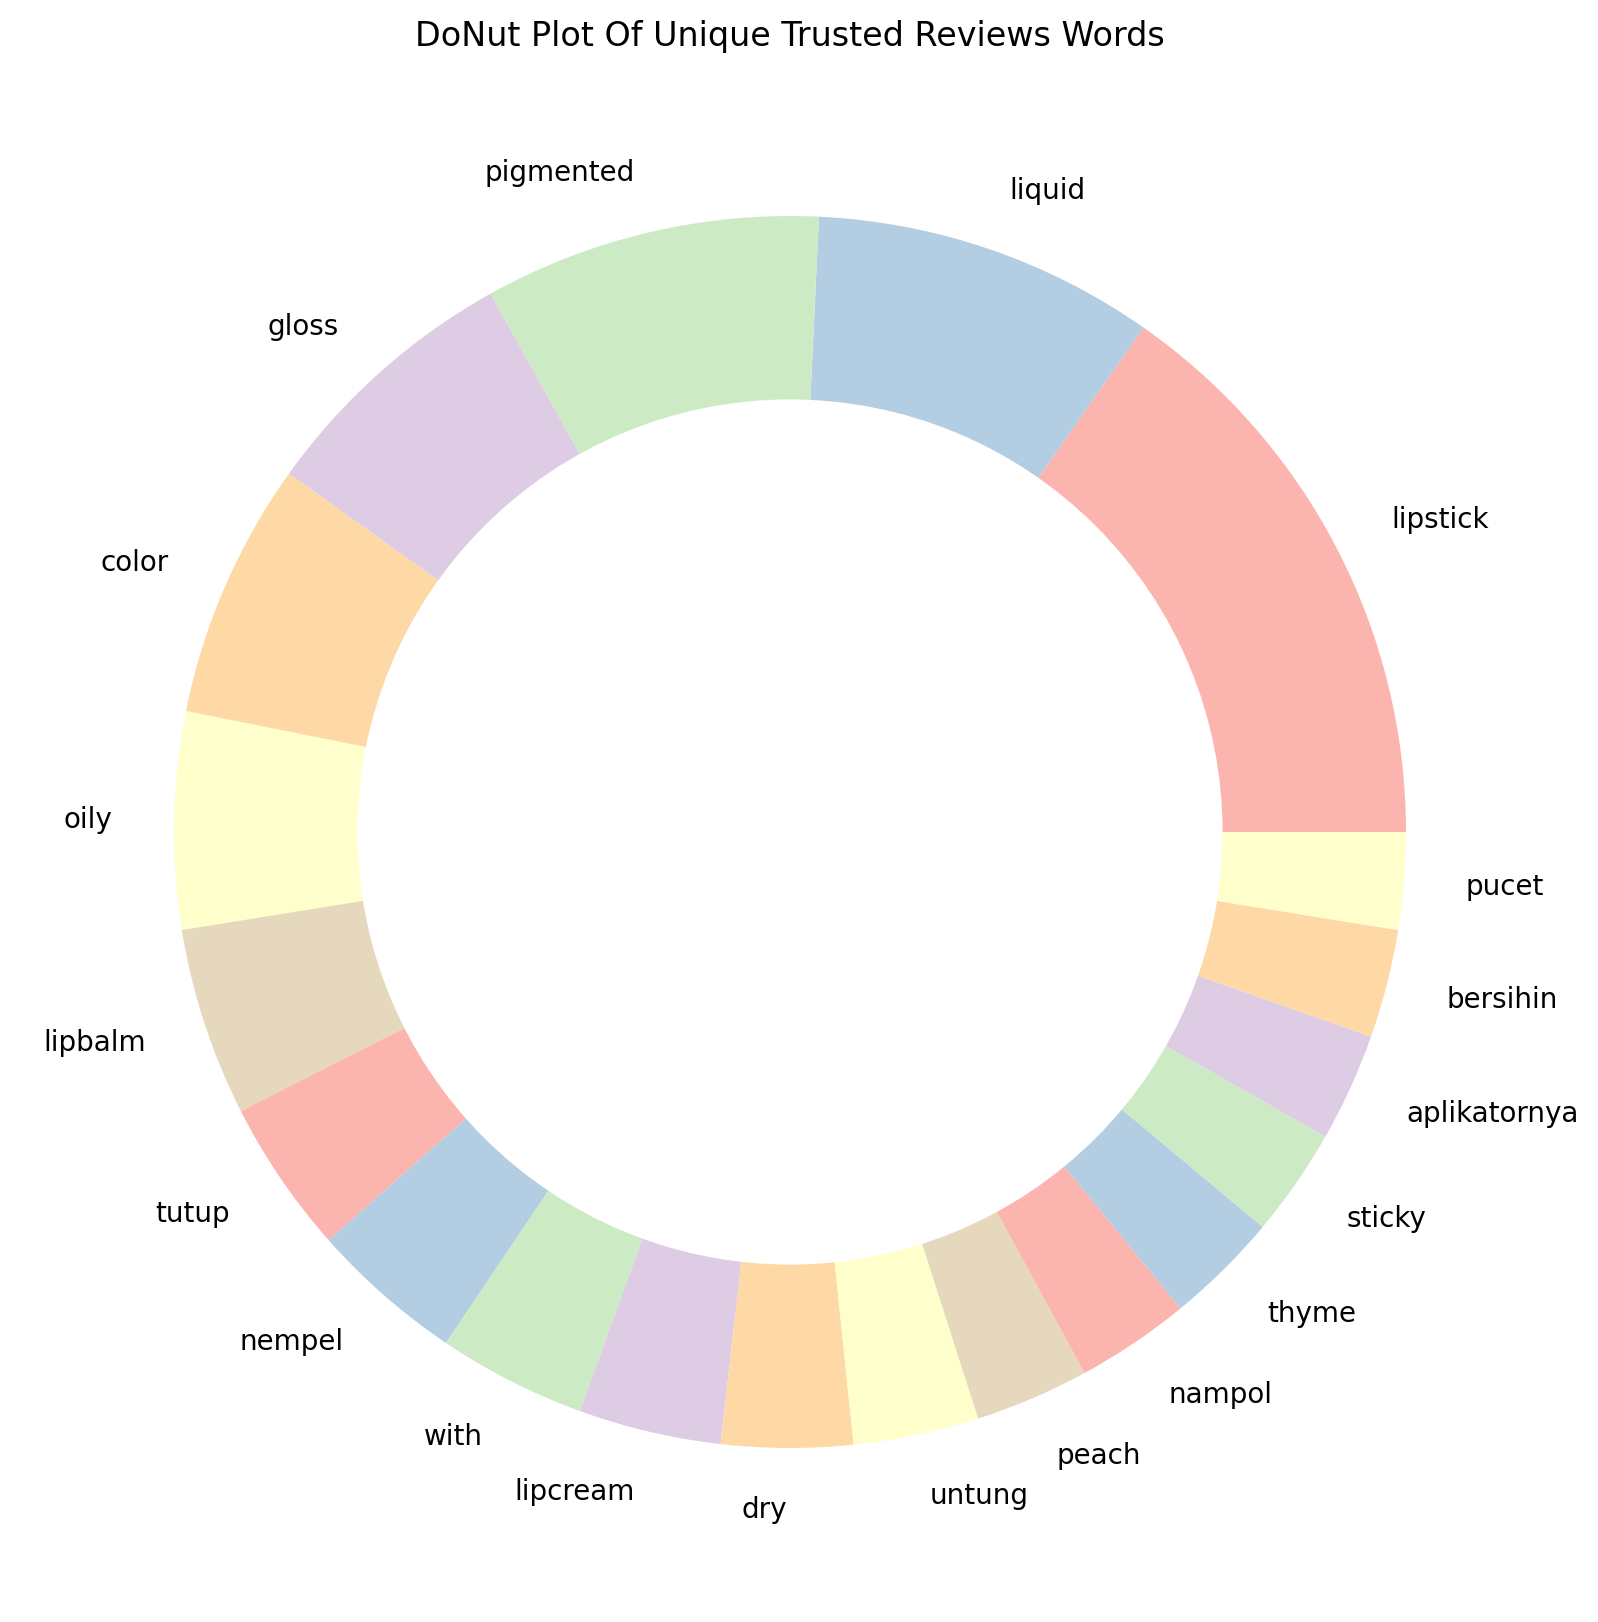

In [278]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Trusted['count'], labels=Unique_Trusted.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Trusted Reviews Words')
plt.show()

### Fake

In [279]:
Unique_Fake= words_unique('fake', 20, raw_text)
print("The top 10 unique words in Fake Reviews are:")
Unique_Fake.style.background_gradient(cmap='Reds')

The top 10 unique words in Fake Reviews are:


,words,count
0,signifikan,40
1,kesat,9
2,durabilitas,9
3,nyegrak,8
4,layak,7
5,bohong,7
6,pasta,6
7,mukaa,6
8,forever,6
9,berkat,6


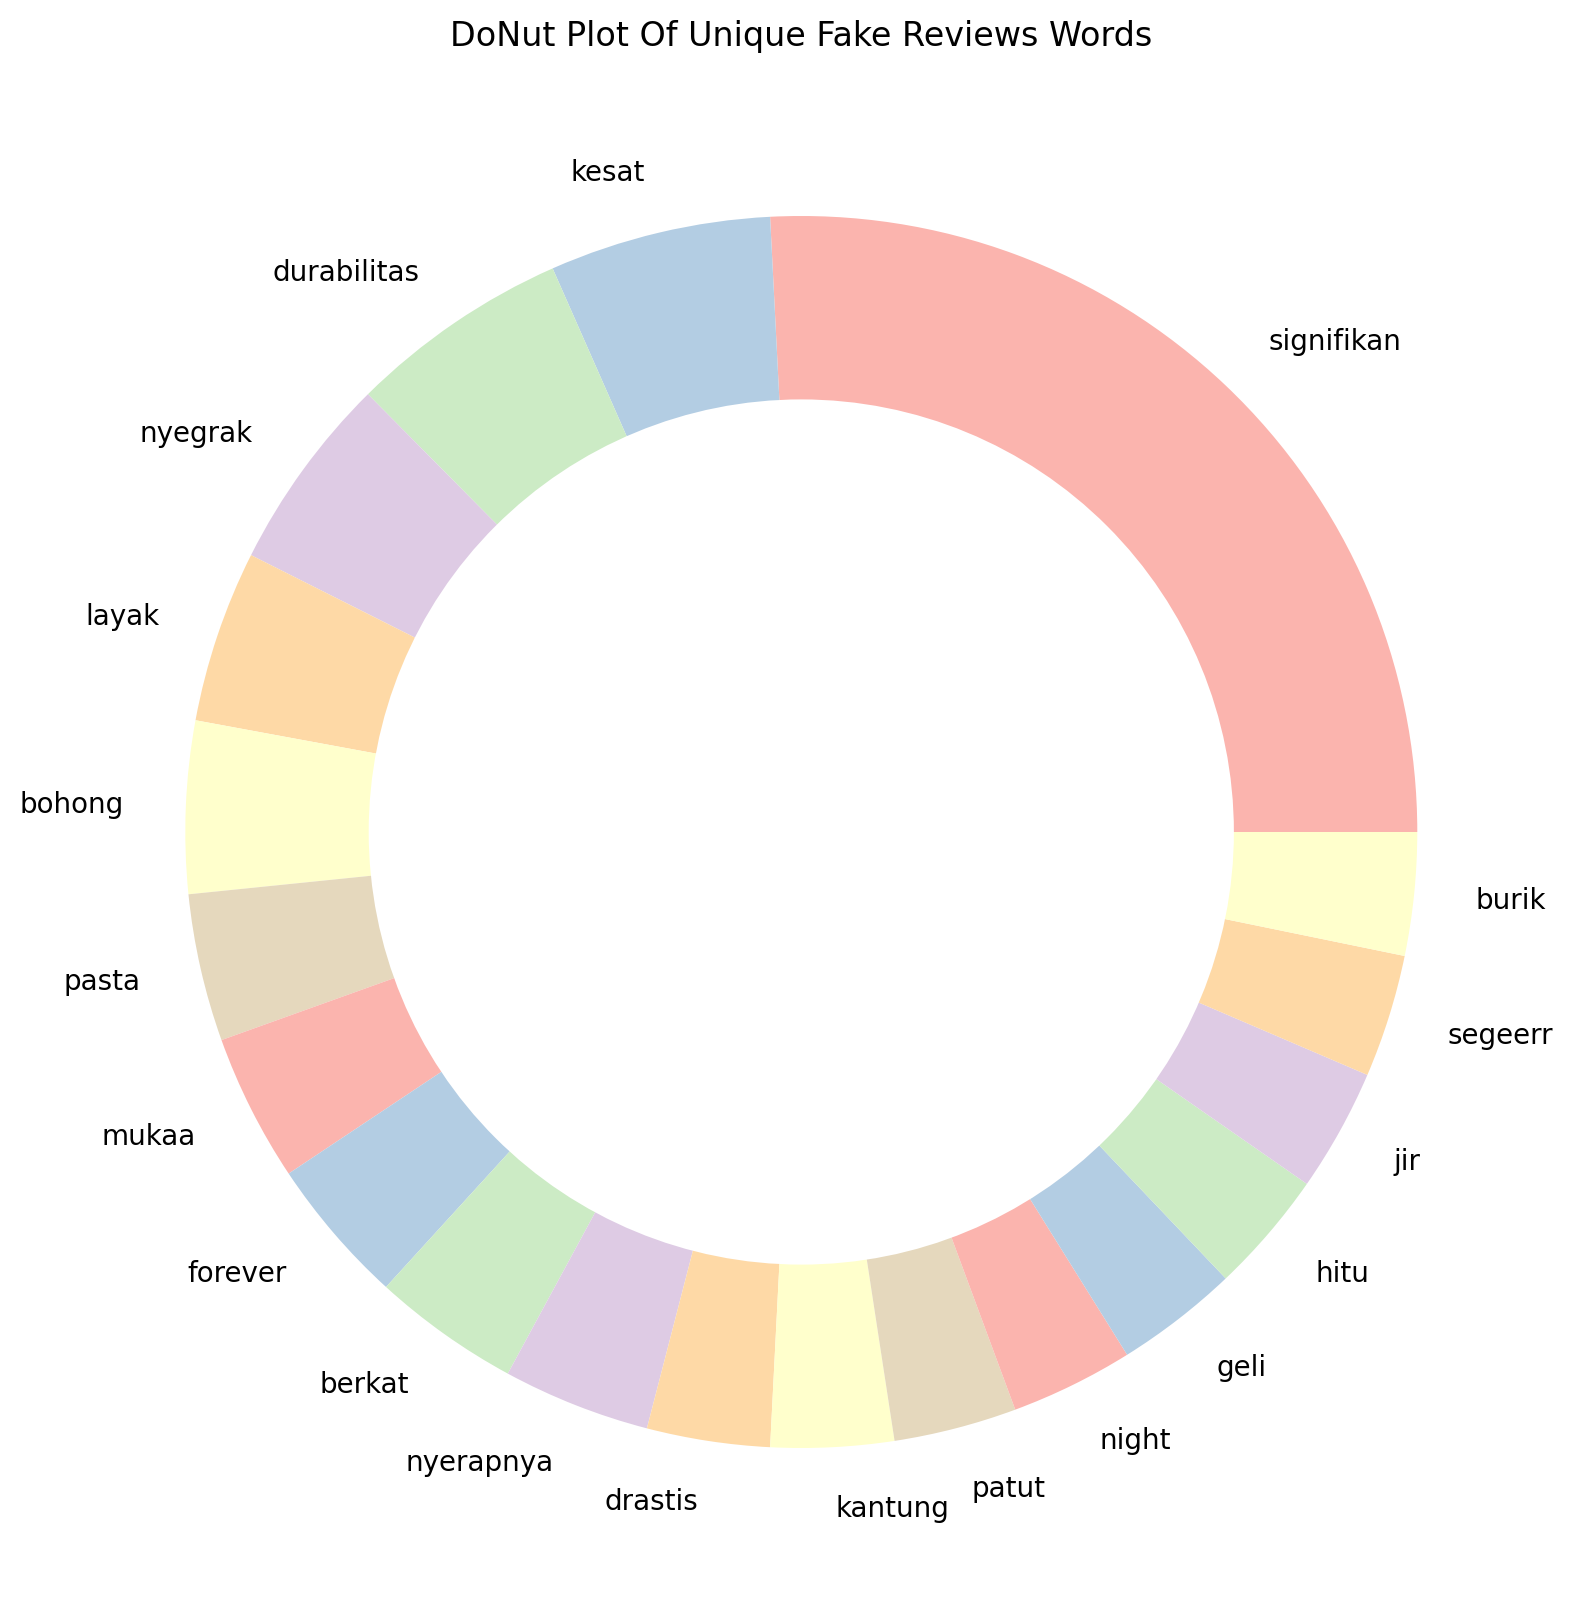

In [280]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Fake['count'], labels=Unique_Fake.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Fake Reviews Words')
plt.show()

### Non

In [281]:
Unique_Non= words_unique('non', 20, raw_text)
print("The top 20 unique words in Non Reviews are:")
Unique_Non.style.background_gradient(cmap='gist_gray_r')

The top 20 unique words in Non Reviews are:


,words,count
0,palsu,64
1,pesan,52
2,berita,33
3,bahaya,23
4,belanja,22
5,ngerokok,19
6,topik,19
7,isu,18
8,aging,17
9,abal,17


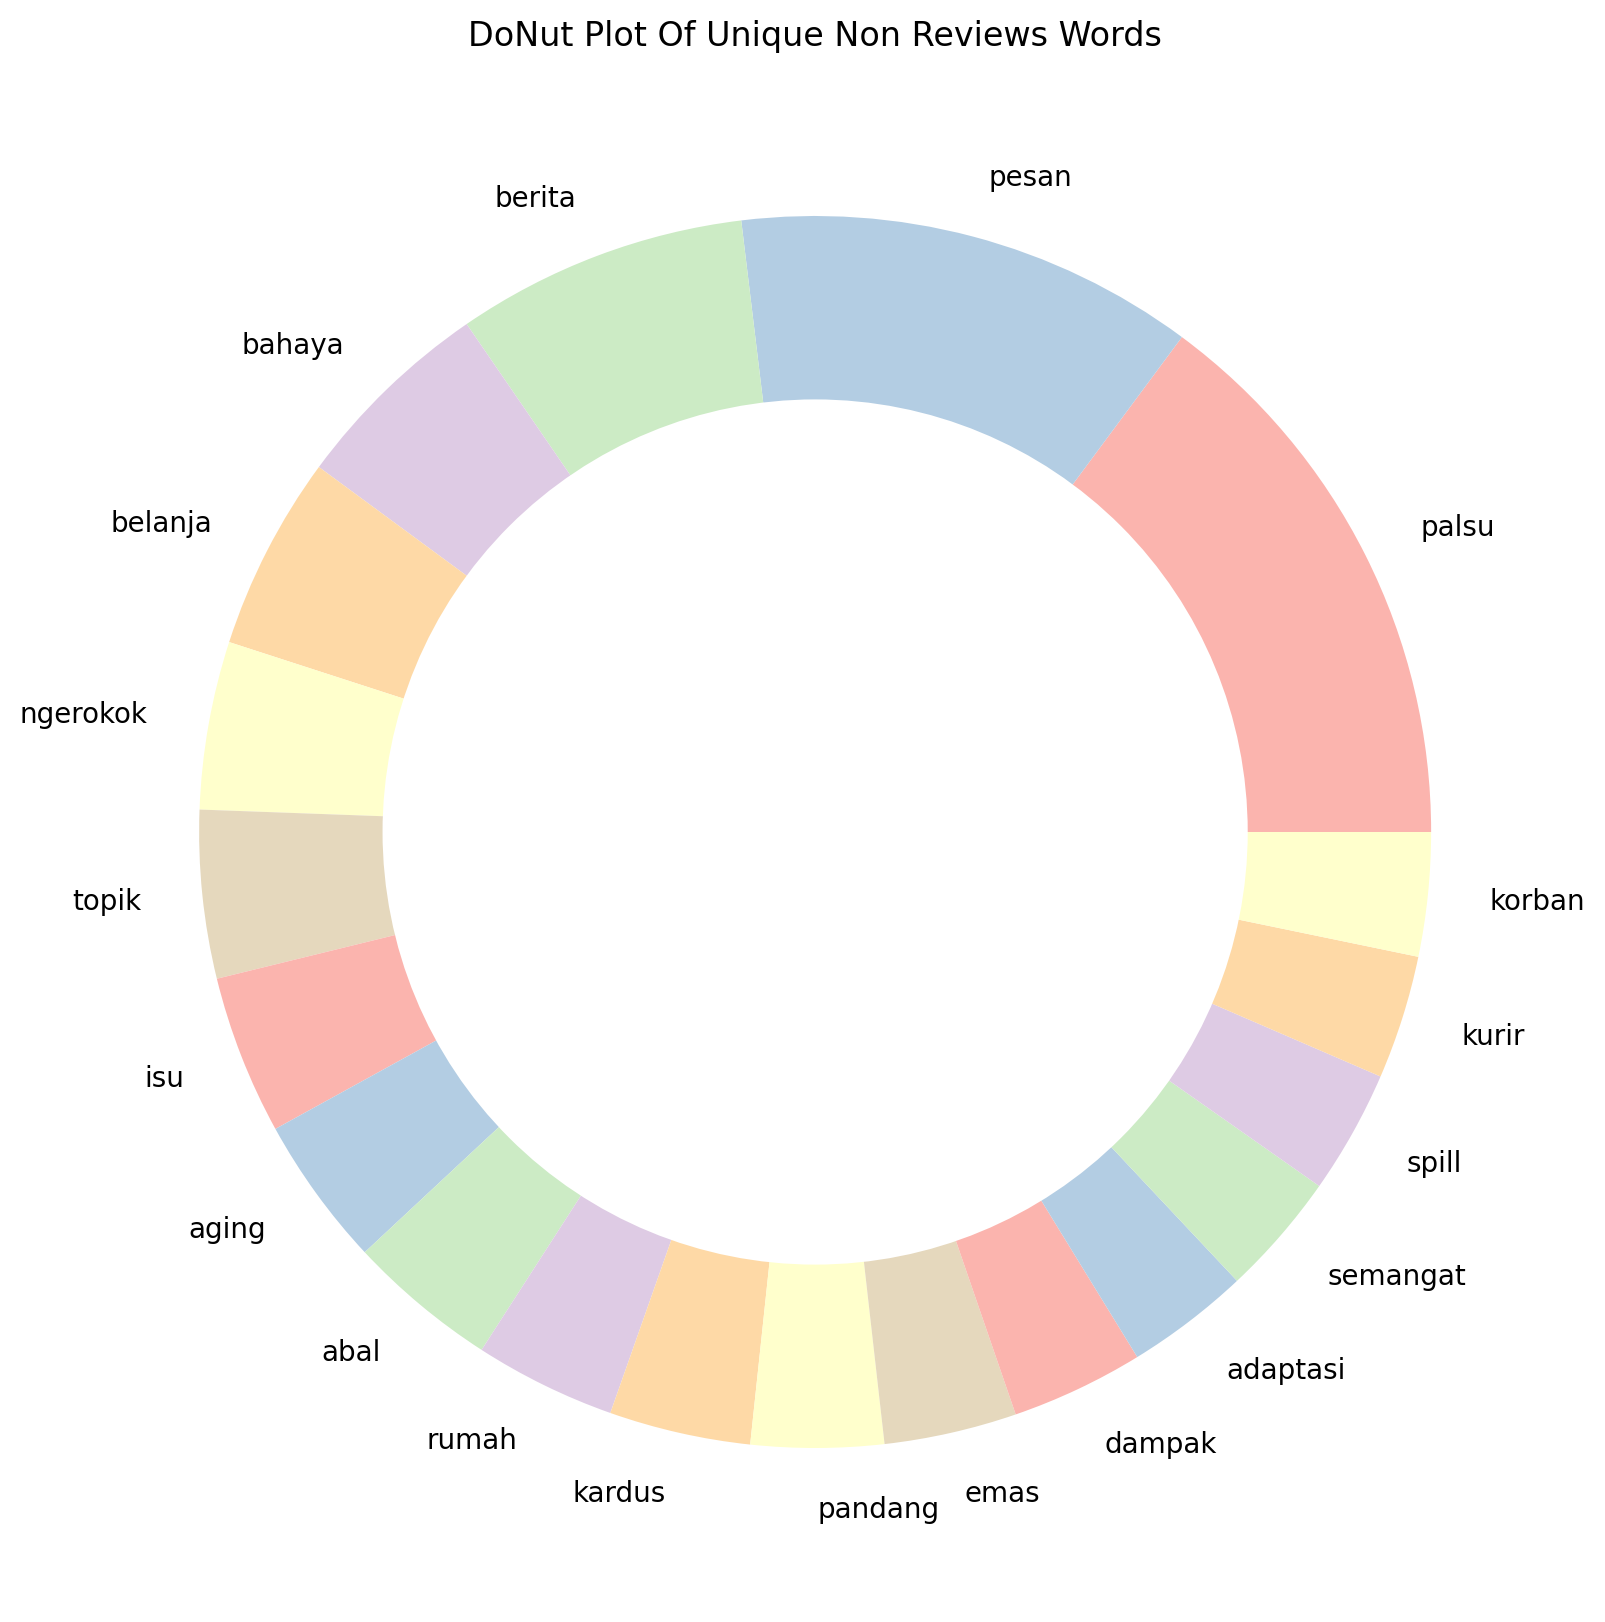

In [282]:
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_Non['count'], labels=Unique_Non.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Non Reviews Words')
plt.show()